In [1]:
import logging
import os
from pathlib import Path

import scanpy as sc
import numpy as np
import pandas as pd
import scipy
import anndata
import squidpy as sq
import matplotlib.pyplot as plt
import tifffile
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from umap import UMAP

/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
from mgitools.os_helpers import listfiles

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from mip.gating import get_ideal_window

Loading BokehJS ...

In [6]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

In [7]:
analysis_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1'
sc.settings.figdir = os.path.join(analysis_dir, 'figures')
Path(os.path.join(analysis_dir, 'figures')).mkdir(parents=True, exist_ok=True)

In [ ]:
fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca',
                       regex=r'dcis_neighborhood_analysis/preprocessed_adata.h5ad$'))
fps

In [ ]:
def cell_to_neighbors(adata, radius=50):
    X = adata.obs[['centroid_row', 'centroid_col']].values
    nbrs = NearestNeighbors(algorithm='ball_tree').fit(X)
    
    g = nbrs.radius_neighbors_graph(X, radius=radius)
    rows, cols, _ = scipy.sparse.find(g)
    
    cell_to_neighbhors = {}
    for r, c in zip(rows, cols):
        cid = adata.obs.index[r]
        if cid not in cell_to_neighbhors:
            cell_to_neighbhors[cid] = []
        else:
            cell_to_neighbhors[cid].append(adata.obs.index[c])
            
    return cell_to_neighbhors

In [ ]:
sample_to_adata = {}
cell_to_nbhrs = {}
for fp in fps:
    sample = fp.split('/')[-4]
    a = sc.read_h5ad(fp)
    print(sample, a.shape)
    
    if 'passes_qc' in a.obs.columns:
        a = a[a.obs['passes_qc']]
        
    a = a[a.obs['harmonized_cell_type']!='Noise']
        
    a.obs['cell_id'] = a.obs.index.to_list()
    a.obs.index = [f'{sample}_{x}' for x in a.obs.index.to_list()]
    cell_to_nbhrs.update(cell_to_neighbors(a, radius=100))
    sample_to_adata[sample] = a

In [ ]:
# fps = sorted(listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/', regex=r'pseudo.tiff$'))
# fps

In [ ]:
# sample_to_pseudo = {fp.split('/')[-3]:tifffile.imread(fp) for fp in fps}

In [ ]:
# sample_to_adata.keys()

In [ ]:
cells = []
docs = []
for s, a in sample_to_adata.items():
    cell_to_cell_type = {c:ct for c, ct in zip(a.obs.index.to_list(), a.obs['harmonized_cell_type'].to_list())}
    docs += [[cell_to_cell_type[neighbor] for neighbor in cell_to_nbhrs[cell_id]]
            for cell_id in a.obs.index.to_list()]
    print(s, len(docs))
    cells += a.obs.index.to_list()

In [ ]:
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
len(dictionary), len(corpus), len(cells)

In [ ]:
num_topics = 10
chunksize = len(corpus)
passes = 2
iterations = 100
eval_every = 10 # turn this on to see how well everything is converging. off by default bc is takes time

In [ ]:
temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
top_topics = model.top_topics(corpus)
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics

In [ ]:
def transformed_corpus_to_emb(tc, n_topics):
    embs = []
    for entity in tc:
        default = [0] * n_topics
        for topic, value in entity:
            default[topic] = value
        embs.append(default)
    return np.asarray(embs)
    

In [ ]:
transformed = model[corpus]
embs = transformed_corpus_to_emb(transformed, num_topics)
embs.shape

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [ ]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(embs)
set(kmeans.labels_)

In [ ]:
df = pd.DataFrame(data=embs, columns=np.arange(num_topics), index=cells)
lda_adata = anndata.AnnData(df)
lda_adata

In [ ]:
lda_adata.obs['LDA_kmeans_cluster'] = [str(x) for x in kmeans.labels_]

In [ ]:
lda_adata.write_h5ad(os.path.join(analysis_dir, 'lda.h5ad'))

In [ ]:
sc.pl.matrixplot(lda_adata, var_names=lda_adata.var.index, groupby='LDA_kmeans_cluster', dendrogram=True,
                 save='lda_kmeans_cluster.pdf')

In [ ]:
topic_df = pd.DataFrame(data=model.get_topics(), columns=[dictionary.get(i) for i in range(len(dictionary))],
                        index=np.arange(num_topics))
import seaborn as sns
sns.clustermap(topic_df, cmap='Blues')
plt.tight_layout()
plt.savefig(os.path.join(analysis_dir, 'figures', 'topic_heatmap.pdf'))

In [ ]:
topic_map = {
    0: 'Immune - M2 macrophage dominant',
    1: 'Mixed Stroma/Immune',
    2: 'Endothelial',
    3: 'Tumor boundary - Immune Low',
    4: 'Immune - M1 macrophage dominant',
    5: 'Tumor boundary - Immune High',
    6: 'Normal Duct',
    7: 'Immune - T cell High',
    8: 'Stroma',
    9: 'Tumor'
}


In [ ]:
for sample, a in sample_to_adata.items():
    for t in lda_adata.var.index:
        a.obsm[f'LDA_topics'] = lda_adata[a.obs.index].X
        a.obs['LDA_kmeans_cluster'] = lda_adata[a.obs.index].obs['LDA_kmeans_cluster'].to_list()
        a.obsm['LDA_topics_named'] = pd.DataFrame(data=lda_adata[a.obs.index].X,
                                                  columns=[topic_map[c] for c in range(lda_adata.shape[1])],
                                                  index=a.obs.index.to_list())
    a.uns['topic_map'] = topic_map

In [10]:
def visualize_roi(adata, scale=1000, size=10, color='harmonized_cell_type'):
    fig, ax = plt.subplots(
        figsize=(int(max(adata.obs['centroid_col']) / scale), int(max(adata.obs['centroid_row']) / scale)))
    sc.pl.scatter(adata, x='centroid_col', y='centroid_row_inverted',
                  color=color, size=size, ax=ax)
    
def visualize_topics(adata, size=2, n_cols=5, scale=3):
    ratio = max(adata.obs['centroid_row']) / max(adata.obs['centroid_col'])
    n_topics = len([c for c in adata.obs.columns if 'topic' in c])
    n_rows = (n_topics // n_cols) + 1
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(n_cols * scale, n_rows * (ratio * scale)))
    i = 0
    for r in range(n_rows):
        for c in range(n_cols):
            if i < n_topics:
                ax = axs[r, c]
                ax.scatter(adata.obs['centroid_col'], adata.obs['centroid_row_inverted'],
                           s=size, c=adata.obsm['LDA_topics_named'][topic_map[i]])
                ax.set_xticks([])
                ax.set_yticks([])
#                 ax.set_title(f'topic_{i}')
                ax.set_title(topic_map[i])
            i += 1

In [ ]:
visualize_topics(next(iter(sample_to_adata.values())))

In [ ]:
for s, a in sample_to_adata.items():
    print(s)
    visualize_roi(a)

In [ ]:
for s, a in sample_to_adata.items():
    print(s)
    visualize_roi(a, color='LDA_kmeans_cluster')

exporting to qitissue cluster file

In [ ]:
for sample, a in sample_to_adata.items():
    df = a.obs[['LDA_kmeans_cluster', 'cell_id']]
    df = df.set_index('cell_id')
    df.index.name = 'CellID'
    df.columns = ['Cluster']
    directory = os.path.join(analysis_dir, 'qitissue')
    Path(directory).mkdir(parents=True, exist_ok=True)
    df.to_csv(os.path.join(directory, f'kmeans_cluster_file_{sample}.csv'))

In [ ]:
topic_map

In [ ]:
p = lda_adata.copy()
p.var.index = [topic_map[int(i)] for i in lda_adata.var.index]
sc.pl.matrixplot(p, var_names=p.var.index, groupby='LDA_kmeans_cluster', dendrogram=True,
                 save='lda_kmeans_cluster_named.pdf')

In [ ]:
topic_df = pd.DataFrame(data=model.get_topics(), columns=[dictionary.get(i) for i in range(len(dictionary))],
                        index=[topic_map[i] for i in np.arange(num_topics)])
import seaborn as sns
sns.clustermap(topic_df, cmap='Blues')
plt.tight_layout()
plt.savefig(os.path.join(analysis_dir, 'figures', 'topic_heatmap_named.pdf'))

In [ ]:
metacluster_to_cluster = {
    'Tumor Boundary - Stroma Enriched 1': [13],
    'Tumor': [1, 14],
    'Myoepithelial': [4, 10, 17],
    'Tumor Boundary - M2 Macrophage Enriched': [0],
    'Tumor Boundary - Mixed Immune Enriched': [16],
    'Tumor Boundary - Stroma Enriched 2': [8, 3],
    'Macrophage M1 enriched': [2, 15],
    'Tumor Boundary - Mixed': [9],
    'Mixed Immune/Stroma': [18, 6, 5],
    'Stroma': [7],
    'T cell Enriched': [11],
    'Endothelial': [19],
    'Macrophage M2 - enriched': [12],
    
}
cluster_to_metacluster = {str(v):k for k, vs in metacluster_to_cluster.items() for v in vs}
sorted(cluster_to_metacluster.items())

In [ ]:
cell_to_kmeans = {c:str(k) for c, k in zip(cells, kmeans.labels_)}
cell_to_metacluster = {c:cluster_to_metacluster[cell_to_kmeans[c]]
                      for c in cells}
for s, a in sample_to_adata.items():
    a.obsm['X_lda'] = lda_adata[a.obs.index.to_list()].X
    a.obs['metacluster'] = [cell_to_metacluster[c] for c in a.obs.index.to_list()]

In [ ]:
for s, a in sample_to_adata.items():
    print(s)
    visualize_roi(a, color='metacluster')

In [ ]:
order = sorted(set(next(iter(sample_to_adata.values())).obs['metacluster']))
[(i + 1, o) for i, o in enumerate(order)]

In [ ]:
for sample, a in sample_to_adata.items():
    df = a.obs[['metacluster', 'cell_id']]
    df = df.set_index('cell_id')
    df.index.name = 'CellID'
    df.columns = ['Cluster']
    df['Cluster'] = [order.index(x) + 1 for x in df['Cluster']]
    directory = os.path.join(analysis_dir, 'qitissue')
    Path(directory).mkdir(parents=True, exist_ok=True)
    df.to_csv(os.path.join(directory, f'metacluster_{sample}.csv'))

In [ ]:
for s, a in sample_to_adata.items():
    # topic map wont save with int
    a.uns['topic_map'] = {str(k):v for k, v in a.uns['topic_map'].items()}
    directory = os.path.join(analysis_dir, 'metaclustered')
    Path(directory).mkdir(parents=True, exist_ok=True)
    a.write_h5ad(os.path.join(directory, f'{s}.h5ad'))

In [ ]:
from collections import Counter
data, idxs = [], []
cols = sorted(set(cell_to_metacluster.values()))
for s, a in sample_to_adata.items():
    counts = Counter(a.obs['metacluster'])
    data.append([counts.get(c, 0) for c in cols])
    idxs.append(s)
df = pd.DataFrame(data=data, index=idxs, columns=cols)
df

In [ ]:
ax = df.plot(kind='bar', stacked=True, color=sns.color_palette('tab20'))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
ax = (df / df.sum(axis=1).values.reshape(-1, 1)).plot(kind='bar', stacked=True, color=sns.color_palette('tab20'))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
data, idxs = [], []
cols = sorted(set(a.obs['harmonized_cell_type']))
for s, a in sample_to_adata.items():
    counts = Counter(a.obs['harmonized_cell_type'])
    data.append([counts.get(c, 0) for c in cols])
    idxs.append(s)
df = pd.DataFrame(data=data, index=idxs, columns=cols)
df

In [ ]:
ax = df.plot(kind='bar', stacked=True, color=sns.color_palette('tab20'))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
ax = (df / df.sum(axis=1).values.reshape(-1, 1)).plot(kind='bar', stacked=True, color=sns.color_palette('tab20'))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

for spatial analyses to work we need to format the anndata object how squidpy expects

In [ ]:
for s, a in sample_to_adata.items():
    a.obsm['spatial'] = a.obs[['centroid_col', 'centroid_row']].values

In [ ]:
directory = os.path.join(analysis_dir, 'distance_metrics')
Path(directory).mkdir(parents=True, exist_ok=True)
for s, a in sample_to_adata.items():
    print(s)
    sq.gr.spatial_neighbors(a, key_added='spatial')
    sq.gr.interaction_matrix(a, cluster_key="metacluster")
    sq.gr.co_occurrence(a, cluster_key="metacluster", n_splits=1, n_jobs=40,
                        interval=[32, 64, 128, 256])
    sq.gr.interaction_matrix(a, cluster_key="harmonized_cell_type")
    sq.gr.co_occurrence(a, cluster_key="harmonized_cell_type", n_splits=1, n_jobs=40,
                        interval=[32, 64, 128, 256])
    a.write_h5ad(os.path.join(directory, f'{s}.h5ad'))

In [ ]:
# sq.pl.interaction_matrix(a, cluster_key="metacluster", vmax=10000)

In [ ]:
for s, a in sample_to_adata.items():
    sq.pl.co_occurrence(
        a,
        cluster_key="metacluster",
        clusters=["Tumor"],
        figsize=(15, 4),
    )
    plt.title(s)
    plt.show()

In [ ]:
for s, a in sample_to_adata.items():
    sq.pl.co_occurrence(
        a,
        cluster_key="harmonized_cell_type",
        clusters=["Tumor"],
        figsize=(15, 4),
    )
    plt.title(s)
    plt.show()

In [ ]:
for s, a in sample_to_adata.items():
    f = a[a.obs['harmonized_cell_type']=='Tumor']
    scores = f.raw[:, 'MGP'].X.flatten()
    for i, metacluster in enumerate(order):
        y_true = [1 if m==metacluster else 0
                  for m in f.obs['metacluster']]
        fpr, tpr, thresholds = roc_curve(y_true, scores)
        plt.plot(fpr, tpr, label=metacluster, c=sns.color_palette('tab20')[i])
    plt.title(s)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

In [ ]:
data = None
for s, a in sample_to_adata.items():
    f = a[a.obs['harmonized_cell_type']=='Tumor'].copy()
    scores = f.raw[:, 'MGP'].X.flatten()
    f.obs['tumor_MGP'] = scores
    df = f.obs[['sample_id', 'tumor_MGP', 'harmonized_cell_type', 'metacluster']]
    
    if data is None:
        data = df
    else:
        data = pd.concat((data, df), axis=0)

    
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=data, x='sample_id', y='tumor_MGP', hue='metacluster', ax=ax, palette=sns.color_palette('tab20'))
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [ ]:
for s, a in sample_to_adata.items():
    ls = a.raw[a.obs['harmonized_cell_type']=='Tumor', 'MGP'].X.flatten()
    ls = np.random.choice(ls, size=5000)
    sns.distplot(ls, label=s)
    plt.legend()

In [ ]:
from skimage.segmentation import find_boundaries
import mip.utils as utils
from mip.gating import gate_region
base_dir = '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca'
sample_to_mgp_img = {}
sample_to_boundary_img = {}
for sample, a in sample_to_adata.items():
    print(sample)
    channel_to_img = utils.extract_ome_tiff(os.path.join(base_dir, sample, 'level_2', f'{sample}.ome.tiff'))
    seg_img = tifffile.imread(os.path.join(base_dir, sample, 'level_3', 'segmentation', 'cell_segmentation.tif'))
    boundary_img = find_boundaries(seg_img)
    
    sample_to_mgp_img[sample] = channel_to_img['MGP'].copy()
    sample_to_boundary_img[sample] = boundary_img
    
    del channel_to_img        

In [ ]:
sample = 'HT323B1-H3'
gate_region(sample_to_adata[sample], 'MGP', channel_img=sample_to_mgp_img[sample],
            boundary_img=sample_to_boundary_img[sample],
            cell_type='Tumor', cell_type_col='harmonized_cell_type',
            default_value=7., radius=2000)

In [ ]:
mgp_thresholds = {
    'HT206B1-H1': 8.57,
    'HT206B1_H1_06252022': 8.3,
    'HT323B1-H1A1': 8.36,
    'HT323B1-H1A4': 8.36,
    'HT323B1-H3': 8.75,
    'HT397B1-H2A2': 7.8,
    'HT397B1-H3A1': 7.25
}

In [ ]:
for sample, val in mgp_thresholds.items():
    a = sample_to_adata[sample]
    a.obs['is_mgp_positive'] = [True if x >= mgp_thresholds[sample] and ct == 'Tumor' else False
                                for ct, x in zip(a.obs['harmonized_cell_type'], a.raw[:, 'MGP'].X.flatten())]

In [ ]:
visualize_roi(sample_to_adata['HT206B1-H1'], color='is_mgp_positive')

In [ ]:
def call_mgp_cell(is_mgp, ct, m):
    if ct == 'Tumor' and is_mgp:
        return 'Tumor - MGP positive'
    elif ct == 'Tumor' and not is_mgp:
        return 'Tumor - MGP negative'
    return m
    
for s, a in sample_to_adata.items():
    a.obs['metacluster_with_mgp'] = pd.Categorical(
        [call_mgp_cell(is_mgp, ct, m)
         for is_mgp, m, ct in zip(a.obs['is_mgp_positive'], a.obs['metacluster'], a.obs['harmonized_cell_type'])])
    
    a.obs['harmonized_cell_type_with_mgp'] = pd.Categorical(
        [call_mgp_cell(is_mgp, ct, m)
         for is_mgp, m, ct in zip(a.obs['is_mgp_positive'], a.obs['harmonized_cell_type'], a.obs['harmonized_cell_type'])])
    

In [ ]:
visualize_roi(sample_to_adata['HT206B1-H1'], color='metacluster_with_mgp')

In [ ]:
visualize_roi(sample_to_adata['HT206B1-H1'], color='harmonized_cell_type_with_mgp')

In [ ]:
directory = os.path.join(analysis_dir, 'distance_metrics')
for s, a in sample_to_adata.items():
    print(s)
    sq.gr.interaction_matrix(a, cluster_key="metacluster_with_mgp")
    sq.gr.co_occurrence(a, cluster_key="metacluster_with_mgp", n_splits=1, n_jobs=40,
                        interval=[32, 64, 128, 256])
    sq.gr.interaction_matrix(a, cluster_key="harmonized_cell_type_with_mgp")
    sq.gr.co_occurrence(a, cluster_key="harmonized_cell_type_with_mgp", n_splits=1, n_jobs=40,
                        interval=[32, 64, 128, 256])
    a.write_h5ad(os.path.join(directory, f'{s}.h5ad'))

In [ ]:
a = sample_to_adata['HT206B1-H1']
a

In [ ]:
sq.pl.interaction_matrix(a, cluster_key="metacluster_with_mgp", vmax=10000)

In [ ]:
for sample, a in sample_to_adata.items():
    sq.pl.interaction_matrix(a, cluster_key="metacluster_with_mgp", vmax=50000)
    plt.title(sample)
    plt.show()

## sandbox

In [8]:
directory = os.path.join(analysis_dir, 'distance_metrics')
fps = sorted(listfiles(directory, regex=r'.h5ad$'))
fps

['/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/distance_metrics/HT206B1-H1.h5ad',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/distance_metrics/HT206B1_H1_06252022.h5ad',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/distance_metrics/HT323B1-H1A1.h5ad',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/distance_metrics/HT323B1-H1A4.h5ad',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/distance_metrics/HT323B1-H3.h5ad',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/distance_metrics/HT397B1-H2A2.h5ad',
 '/diskmnt/Projects/Users/estorrs/multiplex_data/analysis/brca_dcis_v1/distance_metrics/HT397B1-H3A1.h5ad']

In [9]:
sample_to_adata = {fp.split('/')[-1].split('.')[0]:sc.read_h5ad(fp) for fp in fps}

2022-08-05 08:23:07,551 : DEBUG : Creating converter from 3 to 5


In [11]:
a = sample_to_adata['HT206B1-H1']
a

AnnData object with n_obs × n_vars = 134846 × 14
    obs: 'area', 'perimeter', 'bbox_row_min', 'bbox_col_min', 'bbox_row_max', 'bbox_col_max', 'centroid_row', 'centroid_col', 'eccentricity', 'DAPI intensity max', 'CD31 intensity max', 'E-cadherin intensity max', 'CD4 intensity max', 'CD20 intensity max', 'Ki67 intensity max', 'CD68 intensity max', 'Pan-CK intensity max', 'CD8 intensity max', 'Histone H3 Pho intensity max', 'CD163 intensity max', 'Podoplanin intensity max', 'CD3 intensity max', 'CD36 intensity max', 'HIF1a intensity max', 'GLUT1 intensity max', 'GATA3 intensity max', 'CD45RO intensity max', 'CD45RA intensity max', 'SMA intensity max', 'CK19 intensity max', 'MGP intensity max', 'Vimentin intensity max', 'Maspin intensity max', 'Foxp3 intensity max', 'MMP9 intensity max', 'HLA-DR intensity max', 'CK14 intensity max', 'CD11c intensity max', 'CD44 intensity max', 'DAPI intensity min', 'CD31 intensity min', 'E-cadherin intensity min', 'CD4 intensity min', 'CD20 intensity min

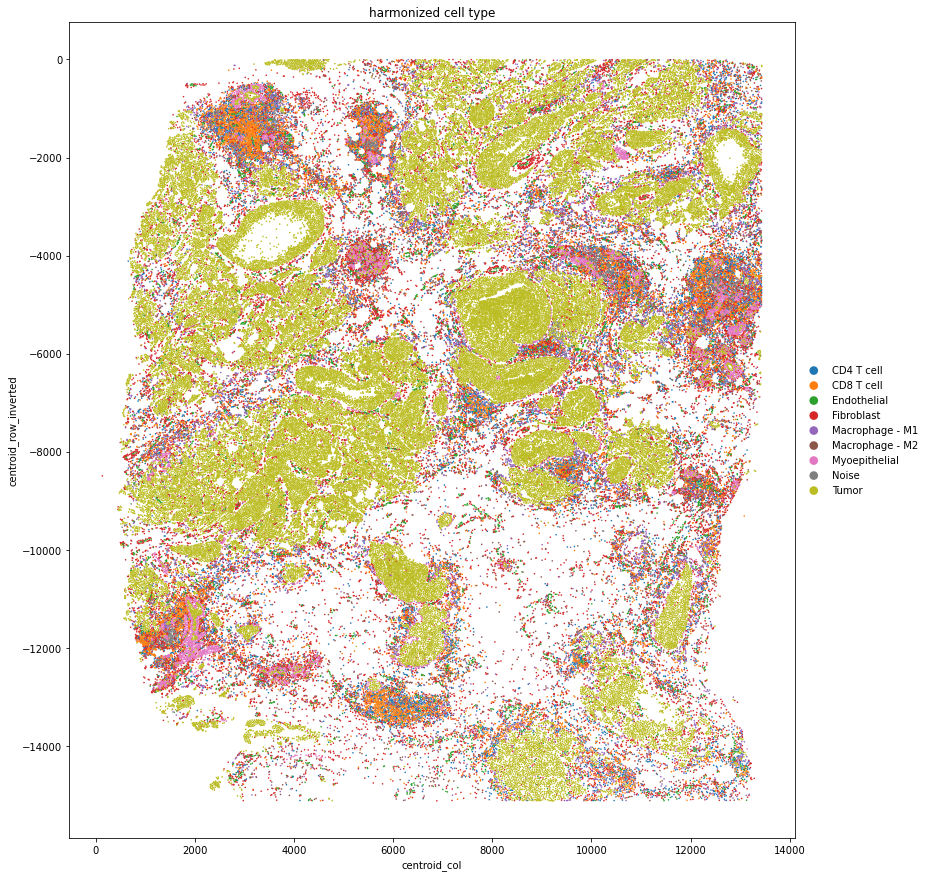

<Figure size 432x288 with 0 Axes>

In [14]:
visualize_roi(a, color='harmonized_cell_type')
plt.savefig(os.path.join(sc.settings.figdir, 'HT206B1-H1_cell_types.pdf'))

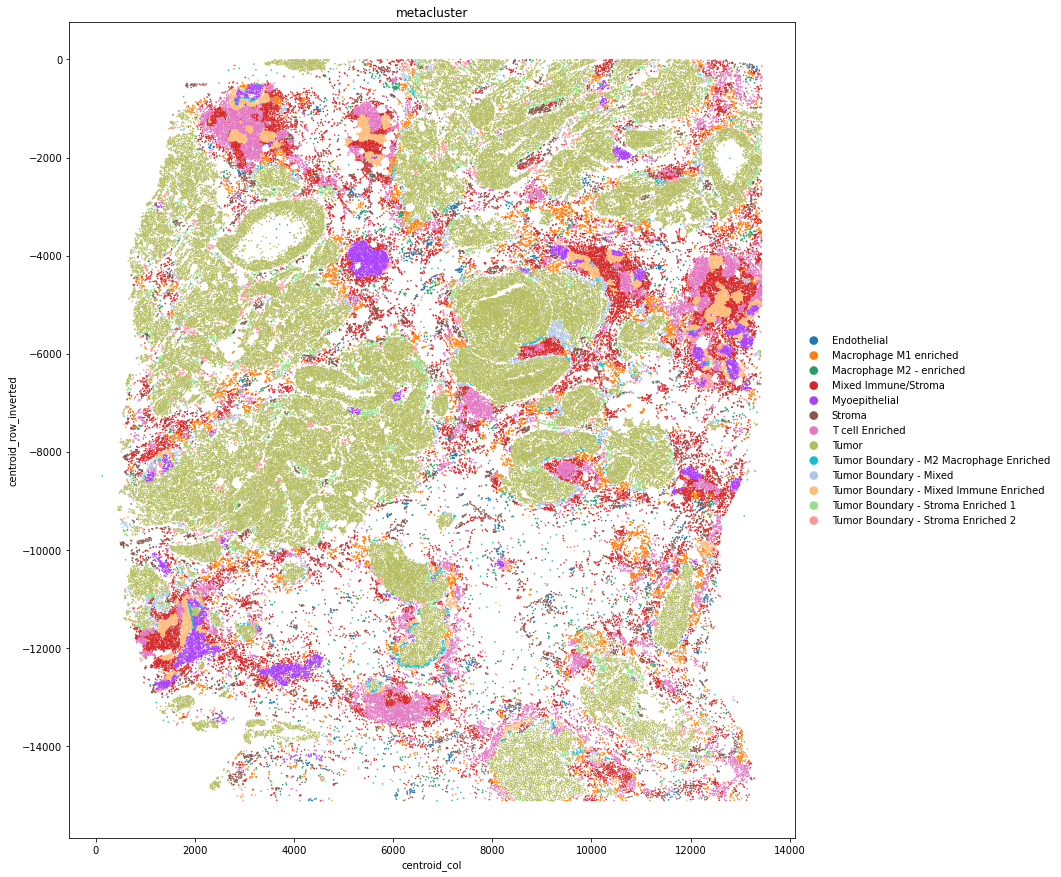

<Figure size 432x288 with 0 Axes>

In [15]:
visualize_roi(a, color='metacluster')
plt.savefig(os.path.join(sc.settings.figdir, 'HT206B1-H1_metaclusters.pdf'))

2022-08-05 08:29:49,189 : DEBUG : Executing constrainedlayout
2022-08-05 08:29:49,340 : DEBUG : Assigning font /b'F1' = '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2022-08-05 08:29:49,387 : DEBUG : Assigning font /b'F2' = '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf'
2022-08-05 08:29:49,425 : DEBUG : Embedding font /diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf.
2022-08-05 08:29:49,427 : DEBUG : Writing TrueType font.
2022-08-05 08:29:49,446 : DEBUG : Embedding font /diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2022-08-05 08:29:49,447 : DEBUG : Writing TrueType font.
2022-08-05 08:29:49,477 : DEBUG : Executing constrainedlayout


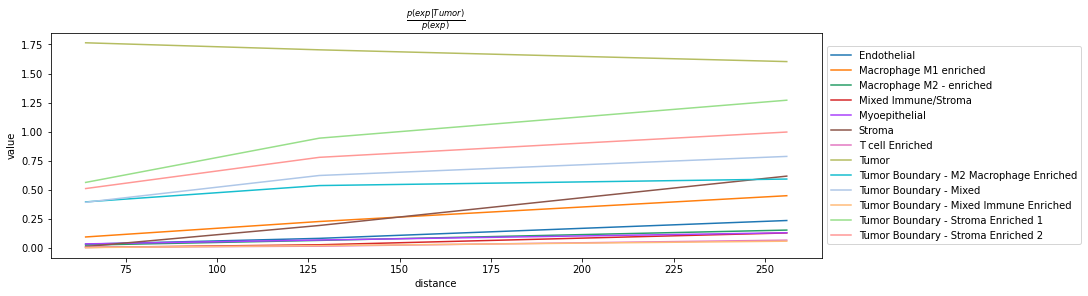

In [17]:
sq.pl.co_occurrence(
    a,
    cluster_key="metacluster",
    clusters=["Tumor"],
    figsize=(15, 4),
    save=os.path.join(sc.settings.figdir, 'HT206B1-H1_metacluster_distances_tumor.pdf')
)

In [22]:
sq.gr.nhood_enrichment(a, cluster_key='metacluster')

2022-08-05 16:41:31,054 : DEBUG : bytecode dump:
>          0	NOP(arg=None, lineno=21)
           2	LOAD_GLOBAL(arg=0, lineno=21)
           4	LOAD_ATTR(arg=1, lineno=21)
           6	LOAD_FAST(arg=1, lineno=21)
           8	LOAD_ATTR(arg=2, lineno=21)
          10	LOAD_CONST(arg=1, lineno=21)
          12	BINARY_SUBSCR(arg=None, lineno=21)
          14	LOAD_CONST(arg=2, lineno=21)
          16	BINARY_SUBTRACT(arg=None, lineno=21)
          18	LOAD_CONST(arg=3, lineno=21)
          20	BUILD_TUPLE(arg=2, lineno=21)
          22	LOAD_GLOBAL(arg=3, lineno=21)
          24	LOAD_CONST(arg=4, lineno=21)
          26	CALL_FUNCTION_KW(arg=2, lineno=21)
          28	STORE_FAST(arg=3, lineno=21)
          30	SETUP_LOOP(arg=94, lineno=23)
          32	LOAD_GLOBAL(arg=4, lineno=23)
          34	LOAD_FAST(arg=3, lineno=23)
          36	LOAD_ATTR(arg=2, lineno=23)
          38	LOAD_CONST(arg=1, lineno=23)
          40	BINARY_SUBSCR(arg=None, lineno=23)
          42	CALL_FUNCTION(arg=1, lineno=23)
  

2022-08-05 16:41:31,056 : DEBUG : pending: deque([State(pc_initial=0 nstack_initial=0)])
2022-08-05 16:41:31,057 : DEBUG : stack: []
2022-08-05 16:41:31,058 : DEBUG : dispatch pc=0, inst=NOP(arg=None, lineno=21)
2022-08-05 16:41:31,058 : DEBUG : stack []
2022-08-05 16:41:31,059 : DEBUG : dispatch pc=2, inst=LOAD_GLOBAL(arg=0, lineno=21)
2022-08-05 16:41:31,060 : DEBUG : stack []
2022-08-05 16:41:31,060 : DEBUG : dispatch pc=4, inst=LOAD_ATTR(arg=1, lineno=21)
2022-08-05 16:41:31,061 : DEBUG : stack ['$2load_global.0']
2022-08-05 16:41:31,062 : DEBUG : dispatch pc=6, inst=LOAD_FAST(arg=1, lineno=21)
2022-08-05 16:41:31,062 : DEBUG : stack ['$4load_attr.1']
2022-08-05 16:41:31,063 : DEBUG : dispatch pc=8, inst=LOAD_ATTR(arg=2, lineno=21)
2022-08-05 16:41:31,063 : DEBUG : stack ['$4load_attr.1', '$indptr6.2']
2022-08-05 16:41:31,064 : DEBUG : dispatch pc=10, inst=LOAD_CONST(arg=1, lineno=21)
2022-08-05 16:41:31,065 : DEBUG : stack ['$4load_attr.1', '$8load_attr.3']
2022-08-05 16:41:31,065

2022-08-05 16:41:31,113 : DEBUG : stack ['$phi48.0', '$indices72.10', '$78build_slice.14']
2022-08-05 16:41:31,113 : DEBUG : dispatch pc=82, inst=STORE_FAST(arg=7, lineno=25)
2022-08-05 16:41:31,114 : DEBUG : stack ['$phi48.0', '$80binary_subscr.15']
2022-08-05 16:41:31,115 : DEBUG : end state. edges=[Edge(pc=84, stack=('$phi48.0',), blockstack=({'kind': BlockKind(LOOP), 'end': 126, 'entry_stack': 0, 'stack_depth': 0, 'handler': None},), npush=0)]
2022-08-05 16:41:31,115 : DEBUG : pending: deque([State(pc_initial=126 nstack_initial=0), State(pc_initial=84 nstack_initial=1)])
2022-08-05 16:41:31,116 : DEBUG : stack: []
2022-08-05 16:41:31,116 : DEBUG : dispatch pc=126, inst=LOAD_GLOBAL(arg=0, lineno=29)
2022-08-05 16:41:31,117 : DEBUG : stack []
2022-08-05 16:41:31,117 : DEBUG : dispatch pc=128, inst=LOAD_ATTR(arg=1, lineno=29)
2022-08-05 16:41:31,118 : DEBUG : stack ['$126load_global.0']
2022-08-05 16:41:31,119 : DEBUG : dispatch pc=130, inst=LOAD_CONST(arg=5, lineno=29)
2022-08-05 16:

2022-08-05 16:41:31,163 : DEBUG : stack ['$212load_attr.37', '$const214.38', '$216load_global.39', '$const218.40']
2022-08-05 16:41:31,163 : DEBUG : dispatch pc=222, inst=STORE_FAST(arg=15, lineno=35)
2022-08-05 16:41:31,164 : DEBUG : stack ['$220call_function_kw.41']
2022-08-05 16:41:31,164 : DEBUG : dispatch pc=224, inst=LOAD_GLOBAL(arg=0, lineno=36)
2022-08-05 16:41:31,165 : DEBUG : stack []
2022-08-05 16:41:31,165 : DEBUG : dispatch pc=226, inst=LOAD_ATTR(arg=1, lineno=36)
2022-08-05 16:41:31,166 : DEBUG : stack ['$224load_global.42']
2022-08-05 16:41:31,166 : DEBUG : dispatch pc=228, inst=LOAD_CONST(arg=5, lineno=36)
2022-08-05 16:41:31,166 : DEBUG : stack ['$226load_attr.43']
2022-08-05 16:41:31,167 : DEBUG : dispatch pc=230, inst=LOAD_GLOBAL(arg=3, lineno=36)
2022-08-05 16:41:31,167 : DEBUG : stack ['$226load_attr.43', '$const228.44']
2022-08-05 16:41:31,168 : DEBUG : dispatch pc=232, inst=LOAD_CONST(arg=4, lineno=36)
2022-08-05 16:41:31,168 : DEBUG : stack ['$226load_attr.43', 

2022-08-05 16:41:31,222 : DEBUG : dispatch pc=308, inst=SETUP_LOOP(arg=364, lineno=43)
2022-08-05 16:41:31,223 : DEBUG : stack []
2022-08-05 16:41:31,223 : DEBUG : dispatch pc=312, inst=LOAD_GLOBAL(arg=4, lineno=43)
2022-08-05 16:41:31,223 : DEBUG : stack []
2022-08-05 16:41:31,224 : DEBUG : dispatch pc=314, inst=LOAD_FAST(arg=3, lineno=43)
2022-08-05 16:41:31,224 : DEBUG : stack ['$312load_global.0']
2022-08-05 16:41:31,225 : DEBUG : dispatch pc=316, inst=LOAD_ATTR(arg=2, lineno=43)
2022-08-05 16:41:31,225 : DEBUG : stack ['$312load_global.0', '$res314.1']
2022-08-05 16:41:31,225 : DEBUG : dispatch pc=318, inst=LOAD_CONST(arg=1, lineno=43)
2022-08-05 16:41:31,226 : DEBUG : stack ['$312load_global.0', '$316load_attr.2']
2022-08-05 16:41:31,226 : DEBUG : dispatch pc=320, inst=BINARY_SUBSCR(arg=None, lineno=43)
2022-08-05 16:41:31,226 : DEBUG : stack ['$312load_global.0', '$316load_attr.2', '$const318.3']
2022-08-05 16:41:31,227 : DEBUG : dispatch pc=322, inst=CALL_FUNCTION(arg=1, lineno

2022-08-05 16:41:31,250 : DEBUG : stack ['$phi330.0', '$clustering332.2', '$row334.3']
2022-08-05 16:41:31,250 : DEBUG : dispatch pc=338, inst=STORE_FAST(arg=23, lineno=44)
2022-08-05 16:41:31,250 : DEBUG : stack ['$phi330.0', '$336binary_subscr.4']
2022-08-05 16:41:31,251 : DEBUG : dispatch pc=340, inst=LOAD_FAST(arg=23, lineno=46)
2022-08-05 16:41:31,251 : DEBUG : stack ['$phi330.0']
2022-08-05 16:41:31,251 : DEBUG : dispatch pc=342, inst=LOAD_CONST(arg=1, lineno=46)
2022-08-05 16:41:31,252 : DEBUG : stack ['$phi330.0', '$cl340.5']
2022-08-05 16:41:31,252 : DEBUG : dispatch pc=344, inst=COMPARE_OP(arg=2, lineno=46)
2022-08-05 16:41:31,252 : DEBUG : stack ['$phi330.0', '$cl340.5', '$const342.6']
2022-08-05 16:41:31,253 : DEBUG : dispatch pc=346, inst=POP_JUMP_IF_FALSE(arg=366, lineno=46)
2022-08-05 16:41:31,253 : DEBUG : stack ['$phi330.0', '$344compare_op.7']
2022-08-05 16:41:31,254 : DEBUG : end state. edges=[Edge(pc=350, stack=('$phi330.0',), blockstack=({'kind': BlockKind(LOOP), '

2022-08-05 16:41:31,276 : DEBUG : stack ['$phi366.0', '$cl366.1']
2022-08-05 16:41:31,276 : DEBUG : dispatch pc=370, inst=COMPARE_OP(arg=2, lineno=48)
2022-08-05 16:41:31,276 : DEBUG : stack ['$phi366.0', '$cl366.1', '$const368.2']
2022-08-05 16:41:31,277 : DEBUG : dispatch pc=372, inst=POP_JUMP_IF_FALSE(arg=392, lineno=48)
2022-08-05 16:41:31,277 : DEBUG : stack ['$phi366.0', '$370compare_op.3']
2022-08-05 16:41:31,277 : DEBUG : end state. edges=[Edge(pc=376, stack=('$phi366.0',), blockstack=({'kind': BlockKind(LOOP), 'end': 676, 'entry_stack': 0, 'stack_depth': 0, 'handler': None},), npush=0), Edge(pc=392, stack=('$phi366.0',), blockstack=({'kind': BlockKind(LOOP), 'end': 676, 'entry_stack': 0, 'stack_depth': 0, 'handler': None},), npush=0)]
2022-08-05 16:41:31,278 : DEBUG : pending: deque([State(pc_initial=46 nstack_initial=1), State(pc_initial=326 nstack_initial=1), State(pc_initial=376 nstack_initial=1), State(pc_initial=392 nstack_initial=1)])
2022-08-05 16:41:31,278 : DEBUG : pe

2022-08-05 16:41:31,301 : DEBUG : dispatch pc=436, inst=STORE_FAST(arg=12, lineno=53)
2022-08-05 16:41:31,302 : DEBUG : stack ['$phi426.0', '$434inplace_add.5']
2022-08-05 16:41:31,302 : DEBUG : dispatch pc=438, inst=JUMP_FORWARD(arg=230, lineno=53)
2022-08-05 16:41:31,302 : DEBUG : stack ['$phi426.0']
2022-08-05 16:41:31,303 : DEBUG : end state. edges=[Edge(pc=670, stack=('$phi426.0',), blockstack=({'kind': BlockKind(LOOP), 'end': 676, 'entry_stack': 0, 'stack_depth': 0, 'handler': None},), npush=0)]
2022-08-05 16:41:31,303 : DEBUG : pending: deque([State(pc_initial=440 nstack_initial=1), State(pc_initial=326 nstack_initial=1), State(pc_initial=670 nstack_initial=1)])
2022-08-05 16:41:31,303 : DEBUG : stack: ['$phi440.0']
2022-08-05 16:41:31,304 : DEBUG : dispatch pc=440, inst=LOAD_FAST(arg=23, lineno=54)
2022-08-05 16:41:31,304 : DEBUG : stack ['$phi440.0']
2022-08-05 16:41:31,305 : DEBUG : dispatch pc=442, inst=LOAD_CONST(arg=8, lineno=54)
2022-08-05 16:41:31,305 : DEBUG : stack ['$

2022-08-05 16:41:31,328 : DEBUG : dispatch pc=502, inst=LOAD_FAST(arg=22, lineno=59)
2022-08-05 16:41:31,328 : DEBUG : stack ['$phi498.0', '$g6498.1', '$res500.2']
2022-08-05 16:41:31,328 : DEBUG : dispatch pc=504, inst=BINARY_SUBSCR(arg=None, lineno=59)
2022-08-05 16:41:31,329 : DEBUG : stack ['$phi498.0', '$g6498.1', '$res500.2', '$row502.3']
2022-08-05 16:41:31,329 : DEBUG : dispatch pc=506, inst=INPLACE_ADD(arg=None, lineno=59)
2022-08-05 16:41:31,329 : DEBUG : stack ['$phi498.0', '$g6498.1', '$504binary_subscr.4']
2022-08-05 16:41:31,330 : DEBUG : dispatch pc=508, inst=STORE_FAST(arg=15, lineno=59)
2022-08-05 16:41:31,330 : DEBUG : stack ['$phi498.0', '$506inplace_add.5']
2022-08-05 16:41:31,330 : DEBUG : dispatch pc=510, inst=JUMP_FORWARD(arg=158, lineno=59)
2022-08-05 16:41:31,330 : DEBUG : stack ['$phi498.0']
2022-08-05 16:41:31,331 : DEBUG : end state. edges=[Edge(pc=670, stack=('$phi498.0',), blockstack=({'kind': BlockKind(LOOP), 'end': 676, 'entry_stack': 0, 'stack_depth': 0

2022-08-05 16:41:31,355 : DEBUG : dispatch pc=570, inst=LOAD_FAST(arg=18, lineno=65)
2022-08-05 16:41:31,355 : DEBUG : stack ['$phi570.0']
2022-08-05 16:41:31,356 : DEBUG : dispatch pc=572, inst=LOAD_FAST(arg=3, lineno=65)
2022-08-05 16:41:31,356 : DEBUG : stack ['$phi570.0', '$g9570.1']
2022-08-05 16:41:31,356 : DEBUG : dispatch pc=574, inst=LOAD_FAST(arg=22, lineno=65)
2022-08-05 16:41:31,357 : DEBUG : stack ['$phi570.0', '$g9570.1', '$res572.2']
2022-08-05 16:41:31,357 : DEBUG : dispatch pc=576, inst=BINARY_SUBSCR(arg=None, lineno=65)
2022-08-05 16:41:31,357 : DEBUG : stack ['$phi570.0', '$g9570.1', '$res572.2', '$row574.3']
2022-08-05 16:41:31,357 : DEBUG : dispatch pc=578, inst=INPLACE_ADD(arg=None, lineno=65)
2022-08-05 16:41:31,358 : DEBUG : stack ['$phi570.0', '$g9570.1', '$576binary_subscr.4']
2022-08-05 16:41:31,358 : DEBUG : dispatch pc=580, inst=STORE_FAST(arg=18, lineno=65)
2022-08-05 16:41:31,358 : DEBUG : stack ['$phi570.0', '$578inplace_add.5']
2022-08-05 16:41:31,359 :

2022-08-05 16:41:31,382 : DEBUG : pending: deque([State(pc_initial=642 nstack_initial=1), State(pc_initial=656 nstack_initial=1)])
2022-08-05 16:41:31,382 : DEBUG : stack: ['$phi642.0']
2022-08-05 16:41:31,383 : DEBUG : dispatch pc=642, inst=LOAD_FAST(arg=21, lineno=71)
2022-08-05 16:41:31,383 : DEBUG : stack ['$phi642.0']
2022-08-05 16:41:31,383 : DEBUG : dispatch pc=644, inst=LOAD_FAST(arg=3, lineno=71)
2022-08-05 16:41:31,384 : DEBUG : stack ['$phi642.0', '$g12642.1']
2022-08-05 16:41:31,384 : DEBUG : dispatch pc=646, inst=LOAD_FAST(arg=22, lineno=71)
2022-08-05 16:41:31,384 : DEBUG : stack ['$phi642.0', '$g12642.1', '$res644.2']
2022-08-05 16:41:31,385 : DEBUG : dispatch pc=648, inst=BINARY_SUBSCR(arg=None, lineno=71)
2022-08-05 16:41:31,385 : DEBUG : stack ['$phi642.0', '$g12642.1', '$res644.2', '$row646.3']
2022-08-05 16:41:31,385 : DEBUG : dispatch pc=650, inst=INPLACE_ADD(arg=None, lineno=71)
2022-08-05 16:41:31,385 : DEBUG : stack ['$phi642.0', '$g12642.1', '$648binary_subscr.

2022-08-05 16:41:31,397 : DEBUG : changing phismap: defaultdict(<class 'set'>,
            {'$phi120.0': {('$phi84.0', State(pc_initial=84 nstack_initial=1)),
                           ('$phi92.0', State(pc_initial=92 nstack_initial=3))},
             '$phi122.0': {('$phi84.0', State(pc_initial=84 nstack_initial=1)),
                           ('$phi92.0', State(pc_initial=92 nstack_initial=3))},
             '$phi326.0': {('$324get_iter.6',
                            State(pc_initial=308 nstack_initial=0)),
                           ('$phi330.0',
                            State(pc_initial=330 nstack_initial=2)),
                           ('$phi366.0',
                            State(pc_initial=366 nstack_initial=1)),
                           ('$phi402.0',
                            State(pc_initial=402 nstack_initial=1)),
                           ('$phi426.0',
                            State(pc_initial=426 nstack_initial=1)),
                           ('$phi450.0',
   

2022-08-05 16:41:31,407 : DEBUG : changing phismap: defaultdict(<class 'set'>,
            {'$phi120.0': {('$44get_iter.6',
                            State(pc_initial=30 nstack_initial=0))},
             '$phi122.0': {('$44get_iter.6',
                            State(pc_initial=30 nstack_initial=0))},
             '$phi326.0': {('$324get_iter.6',
                            State(pc_initial=308 nstack_initial=0))},
             '$phi330.0': {('$324get_iter.6',
                            State(pc_initial=308 nstack_initial=0))},
             '$phi330.1': {('$326for_iter.2',
                            State(pc_initial=326 nstack_initial=1))},
             '$phi350.0': {('$324get_iter.6',
                            State(pc_initial=308 nstack_initial=0))},
             '$phi366.0': {('$324get_iter.6',
                            State(pc_initial=308 nstack_initial=0))},
             '$phi376.0': {('$324get_iter.6',
                            State(pc_initial=308 nstack_initial=0))

2022-08-05 16:41:31,411 : DEBUG : keep phismap: {'$phi326.0': {('$324get_iter.6', State(pc_initial=308 nstack_initial=0))},
 '$phi330.1': {('$326for_iter.2', State(pc_initial=326 nstack_initial=1))},
 '$phi46.0': {('$44get_iter.6', State(pc_initial=30 nstack_initial=0))},
 '$phi48.1': {('$46for_iter.2', State(pc_initial=46 nstack_initial=1))},
 '$phi90.1': {('$88get_iter.2', State(pc_initial=84 nstack_initial=1))},
 '$phi92.2': {('$90for_iter.3', State(pc_initial=90 nstack_initial=2))}}
2022-08-05 16:41:31,412 : DEBUG : new_out: defaultdict(<class 'dict'>,
            {State(pc_initial=30 nstack_initial=0): {'$phi46.0': '$44get_iter.6'},
             State(pc_initial=46 nstack_initial=1): {'$phi48.1': '$46for_iter.2'},
             State(pc_initial=84 nstack_initial=1): {'$phi90.1': '$88get_iter.2'},
             State(pc_initial=90 nstack_initial=2): {'$phi92.2': '$90for_iter.3'},
             State(pc_initial=308 nstack_initial=0): {'$phi326.0': '$324get_iter.6'},
             State(

2022-08-05 16:41:31,416 : DEBUG : block_infos State(pc_initial=308 nstack_initial=0):
AdaptBlockInfo(insts=((312, {'res': '$312load_global.0'}), (314, {'res': '$res314.1'}), (316, {'item': '$res314.1', 'res': '$316load_attr.2'}), (318, {'res': '$const318.3'}), (320, {'index': '$const318.3', 'target': '$316load_attr.2', 'res': '$320binary_subscr.4'}), (322, {'func': '$312load_global.0', 'args': ['$320binary_subscr.4'], 'res': '$322call_function.5'}), (324, {'value': '$322call_function.5', 'res': '$324get_iter.6'})), outgoing_phis={'$phi326.0': '$324get_iter.6'}, blockstack=(), active_try_block=None, outgoing_edgepushed={326: ('$324get_iter.6',)})
2022-08-05 16:41:31,417 : DEBUG : block_infos State(pc_initial=326 nstack_initial=1):
AdaptBlockInfo(insts=((326, {'iterator': '$phi326.0', 'pair': '$326for_iter.1', 'indval': '$326for_iter.2', 'pred': '$326for_iter.3'}),), outgoing_phis={'$phi330.1': '$326for_iter.2'}, blockstack=({'kind': BlockKind(LOOP), 'end': 676, 'entry_stack': 0, 'stack_

2022-08-05 16:41:31,435 : DEBUG : block_infos State(pc_initial=498 nstack_initial=1):
AdaptBlockInfo(insts=((498, {'res': '$g6498.1'}), (500, {'res': '$res500.2'}), (502, {'res': '$row502.3'}), (504, {'index': '$row502.3', 'target': '$res500.2', 'res': '$504binary_subscr.4'}), (506, {'lhs': '$g6498.1', 'rhs': '$504binary_subscr.4', 'res': '$506inplace_add.5'}), (508, {'value': '$506inplace_add.5'}), (510, {})), outgoing_phis={}, blockstack=({'kind': BlockKind(LOOP), 'end': 676, 'entry_stack': 0, 'stack_depth': 0, 'handler': None},), active_try_block=None, outgoing_edgepushed={670: ('$phi498.0',)})
2022-08-05 16:41:31,435 : DEBUG : block_infos State(pc_initial=512 nstack_initial=1):
AdaptBlockInfo(insts=((512, {'res': '$cl512.1'}), (514, {'res': '$const514.2'}), (516, {'lhs': '$cl512.1', 'rhs': '$const514.2', 'res': '$516compare_op.3'}), (518, {'pred': '$516compare_op.3'})), outgoing_phis={}, blockstack=({'kind': BlockKind(LOOP), 'end': 676, 'entry_stack': 0, 'stack_depth': 0, 'handler'

2022-08-05 16:41:31,440 : DEBUG : block_infos State(pc_initial=674 nstack_initial=0):
AdaptBlockInfo(insts=(), outgoing_phis={}, blockstack=({'kind': BlockKind(LOOP), 'end': 676, 'entry_stack': 0, 'stack_depth': 0, 'handler': None},), active_try_block=None, outgoing_edgepushed={676: ()})
2022-08-05 16:41:31,441 : DEBUG : block_infos State(pc_initial=676 nstack_initial=0):
AdaptBlockInfo(insts=((676, {'res': '$676load_global.0'}), (678, {'item': '$676load_global.0', 'res': '$678load_method.1'}), (680, {'res': '$g0680.2'}), (682, {'res': '$g1682.3'}), (684, {'res': '$g2684.4'}), (686, {'res': '$g3686.5'}), (688, {'res': '$g4688.6'}), (690, {'res': '$g5690.7'}), (692, {'res': '$g6692.8'}), (694, {'res': '$g7694.9'}), (696, {'res': '$g8696.10'}), (698, {'res': '$g9698.11'}), (700, {'res': '$g10700.12'}), (702, {'res': '$g11702.13'}), (704, {'res': '$g12704.14'}), (706, {'items': ['$g0680.2', '$g1682.3', '$g2684.4', '$g3686.5', '$g4688.6', '$g5690.7', '$g6692.8', '$g7694.9', '$g8696.10', '$

2022-08-05 16:41:31,509 : DEBUG : ==== SSA block analysis pass on 0
2022-08-05 16:41:31,509 : DEBUG : Running <numba.core.ssa._GatherDefsHandler object at 0x7f79e888b650>
2022-08-05 16:41:31,510 : DEBUG : on stmt: indices = arg(0, name=indices)
2022-08-05 16:41:31,510 : DEBUG : on stmt: indptr = arg(1, name=indptr)
2022-08-05 16:41:31,511 : DEBUG : on stmt: clustering = arg(2, name=clustering)
2022-08-05 16:41:31,511 : DEBUG : on stmt: $2load_global.0 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:31,511 : DEBUG : on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=zeros)
2022-08-05 16:41:31,512 : DEBUG : on stmt: $8load_attr.3 = getattr(value=indptr, attr=shape)
2022-08-05 16:41:31,512 : DEBUG : on stmt: $const10.4 = const(int, 0)
2022-08-05 16:41:31,512 : DEBUG : on stmt: $12binary_subscr.5 = static_getitem(value=$8load_attr.3, index=0, index_var=$const10.4, fn=<buil

2022-08-05 16:41:31,536 : DEBUG : on stmt: $140load_global.6 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:31,536 : DEBUG : on stmt: $142load_attr.7 = getattr(value=$140load_global.6, attr=zeros)
2022-08-05 16:41:31,537 : DEBUG : on stmt: $const_13.1 = const(int, 13)
2022-08-05 16:41:31,537 : DEBUG : on stmt: $const144.8 = build_tuple(items=[Var($const_13.1, :30)])
2022-08-05 16:41:31,537 : DEBUG : on stmt: $146load_global.9 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:31,538 : DEBUG : on stmt: g1 = call $142load_attr.7($const144.8, func=$142load_attr.7, args=[Var($const144.8, :30)], kws=[('dtype', Var($146load_global.9, :30))], vararg=None, target=None)
2022-08-05 16:41:31,538 : DEBUG : on stmt: $154load_global.12 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:

2022-08-05 16:41:31,556 : DEBUG : on stmt: $const_13.11 = const(int, 13)
2022-08-05 16:41:31,556 : DEBUG : on stmt: $const284.68 = build_tuple(items=[Var($const_13.11, :40)])
2022-08-05 16:41:31,556 : DEBUG : on stmt: $286load_global.69 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:31,556 : DEBUG : on stmt: g11 = call $282load_attr.67($const284.68, func=$282load_attr.67, args=[Var($const284.68, :40)], kws=[('dtype', Var($286load_global.69, :40))], vararg=None, target=None)
2022-08-05 16:41:31,557 : DEBUG : on stmt: $294load_global.72 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:31,557 : DEBUG : on stmt: $296load_attr.73 = getattr(value=$294load_global.72, attr=zeros)
2022-08-05 16:41:31,557 : DEBUG : on stmt: $const_13.12 = const(int, 13)
2022-08-05 16:41:31,558 : DEBUG : on stmt: $const298.74 = build_tuple(items=[Var($const_13.12, :41)])
2022-08-05 16:41:31,558 : DE

2022-08-05 16:41:31,580 : DEBUG : on stmt: jump 670
2022-08-05 16:41:31,580 : DEBUG : ==== SSA block analysis pass on 440
2022-08-05 16:41:31,581 : DEBUG : Running <numba.core.ssa._GatherDefsHandler object at 0x7f79e888b650>
2022-08-05 16:41:31,581 : DEBUG : on stmt: $const442.2 = const(int, 4)
2022-08-05 16:41:31,581 : DEBUG : on stmt: $444compare_op.3 = cl == $const442.2
2022-08-05 16:41:31,582 : DEBUG : on stmt: bool446 = global(bool: <class 'bool'>)
2022-08-05 16:41:31,592 : DEBUG : on stmt: $446pred = call bool446($444compare_op.3, func=bool446, args=(Var($444compare_op.3, :54),), kws=(), vararg=None, target=None)
2022-08-05 16:41:31,592 : DEBUG : on stmt: branch $446pred, 450, 464
2022-08-05 16:41:31,592 : DEBUG : ==== SSA block analysis pass on 450
2022-08-05 16:41:31,593 : DEBUG : Running <numba.core.ssa._GatherDefsHandler object at 0x7f79e888b650>
2022-08-05 16:41:31,593 : DEBUG : on stmt: $456binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022

2022-08-05 16:41:31,616 : DEBUG : on stmt: branch $590pred, 594, 608
2022-08-05 16:41:31,616 : DEBUG : ==== SSA block analysis pass on 594
2022-08-05 16:41:31,617 : DEBUG : Running <numba.core.ssa._GatherDefsHandler object at 0x7f79e888b650>
2022-08-05 16:41:31,617 : DEBUG : on stmt: $600binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:31,617 : DEBUG : on stmt: $602inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g10, rhs=$600binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:31,618 : DEBUG : on stmt: g10 = $602inplace_add.5
2022-08-05 16:41:31,618 : DEBUG : on stmt: jump 670
2022-08-05 16:41:31,618 : DEBUG : ==== SSA block analysis pass on 608
2022-08-05 16:41:31,618 : DEBUG : Running <numba.core.ssa._GatherDefsHandler object at 0x7f79e888b650>
2022-08-05 16:41:31,619 : DEBUG : on stmt: $const610.2 = const(int, 11)
2022-08-05 16:41:31,619 : DEBUG : on stmt: $6

2022-08-05 16:41:31,651 : DEBUG : SSA violators {'g0',
 'g1',
 'g10',
 'g11',
 'g12',
 'g2',
 'g3',
 'g4',
 'g5',
 'g6',
 'g7',
 'g8',
 'g9'}
2022-08-05 16:41:31,651 : DEBUG : Fix SSA violator on var g1
2022-08-05 16:41:31,651 : DEBUG : ==== SSA block rewrite pass on 0
2022-08-05 16:41:31,652 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e892f710>
2022-08-05 16:41:31,652 : DEBUG : on stmt: indices = arg(0, name=indices)
2022-08-05 16:41:31,652 : DEBUG : on stmt: indptr = arg(1, name=indptr)
2022-08-05 16:41:31,653 : DEBUG : on stmt: clustering = arg(2, name=clustering)
2022-08-05 16:41:31,653 : DEBUG : on stmt: $2load_global.0 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:31,653 : DEBUG : on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=zeros)
2022-08-05 16:41:31,654 : DEBUG : on stmt: $8load_attr.3 = getattr(value=indptr, attr=shape)
2022-08-0

2022-08-05 16:41:31,677 : DEBUG : on stmt: g0 = call $128load_attr.1($const130.2, func=$128load_attr.1, args=[Var($const130.2, :29)], kws=[('dtype', Var($132load_global.3, :29))], vararg=None, target=None)
2022-08-05 16:41:31,678 : DEBUG : on stmt: $140load_global.6 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:31,678 : DEBUG : on stmt: $142load_attr.7 = getattr(value=$140load_global.6, attr=zeros)
2022-08-05 16:41:31,678 : DEBUG : on stmt: $const_13.1 = const(int, 13)
2022-08-05 16:41:31,679 : DEBUG : on stmt: $const144.8 = build_tuple(items=[Var($const_13.1, :30)])
2022-08-05 16:41:31,679 : DEBUG : on stmt: $146load_global.9 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:31,679 : DEBUG : on stmt: g1 = call $142load_attr.7($const144.8, func=$142load_attr.7, args=[Var($const144.8, :30)], kws=[('dtype', Var($146load_global.9, :30))], vararg=None, target=None)
2022-08-05

2022-08-05 16:41:31,696 : DEBUG : on stmt: $280load_global.66 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:31,697 : DEBUG : on stmt: $282load_attr.67 = getattr(value=$280load_global.66, attr=zeros)
2022-08-05 16:41:31,697 : DEBUG : on stmt: $const_13.11 = const(int, 13)
2022-08-05 16:41:31,697 : DEBUG : on stmt: $const284.68 = build_tuple(items=[Var($const_13.11, :40)])
2022-08-05 16:41:31,698 : DEBUG : on stmt: $286load_global.69 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:31,698 : DEBUG : on stmt: g11 = call $282load_attr.67($const284.68, func=$282load_attr.67, args=[Var($const284.68, :40)], kws=[('dtype', Var($286load_global.69, :40))], vararg=None, target=None)
2022-08-05 16:41:31,698 : DEBUG : on stmt: $294load_global.72 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2

2022-08-05 16:41:31,721 : DEBUG : on stmt: $434inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g3, rhs=$432binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:31,721 : DEBUG : on stmt: g3 = $434inplace_add.5
2022-08-05 16:41:31,722 : DEBUG : on stmt: jump 670
2022-08-05 16:41:31,722 : DEBUG : ==== SSA block rewrite pass on 440
2022-08-05 16:41:31,722 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e892f710>
2022-08-05 16:41:31,722 : DEBUG : on stmt: $const442.2 = const(int, 4)
2022-08-05 16:41:31,723 : DEBUG : on stmt: $444compare_op.3 = cl == $const442.2
2022-08-05 16:41:31,723 : DEBUG : on stmt: bool446 = global(bool: <class 'bool'>)
2022-08-05 16:41:31,723 : DEBUG : on stmt: $446pred = call bool446($444compare_op.3, func=bool446, args=(Var($444compare_op.3, :54),), kws=(), vararg=None, target=None)
2022-08-05 16:41:31,724 : DEBUG : on stmt: branch $446pred, 450, 464
2022-08-05 16:41:31,

2022-08-05 16:41:31,752 : DEBUG : on stmt: $588compare_op.3 = cl == $const586.2
2022-08-05 16:41:31,752 : DEBUG : on stmt: bool590 = global(bool: <class 'bool'>)
2022-08-05 16:41:31,753 : DEBUG : on stmt: $590pred = call bool590($588compare_op.3, func=bool590, args=(Var($588compare_op.3, :66),), kws=(), vararg=None, target=None)
2022-08-05 16:41:31,753 : DEBUG : on stmt: branch $590pred, 594, 608
2022-08-05 16:41:31,753 : DEBUG : ==== SSA block rewrite pass on 594
2022-08-05 16:41:31,754 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e892f710>
2022-08-05 16:41:31,754 : DEBUG : on stmt: $600binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:31,754 : DEBUG : on stmt: $602inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g10, rhs=$600binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:31,755 : DEBUG : on stmt: g10 = $602inplace_add.5
2022-08-05 16:

2022-08-05 16:41:31,792 : DEBUG : on stmt: res = call $4load_attr.1($20build_tuple.9, func=$4load_attr.1, args=[Var($20build_tuple.9, :21)], kws=[('dtype', Var($22load_global.10, :21))], vararg=None, target=None)
2022-08-05 16:41:31,793 : DEBUG : on stmt: jump 30
2022-08-05 16:41:31,796 : DEBUG : ==== SSA block rewrite pass on 30
2022-08-05 16:41:31,796 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e892f710>
2022-08-05 16:41:31,796 : DEBUG : on stmt: $32load_global.0 = global(prange: <class 'numba.misc.special.prange'>)
2022-08-05 16:41:31,796 : DEBUG : on stmt: $36load_attr.2 = getattr(value=res, attr=shape)
2022-08-05 16:41:31,797 : DEBUG : on stmt: $const38.3 = const(int, 0)
2022-08-05 16:41:31,797 : DEBUG : on stmt: $40binary_subscr.4 = static_getitem(value=$36load_attr.2, index=0, index_var=$const38.3, fn=<built-in function getitem>)
2022-08-05 16:41:31,798 : DEBUG : on stmt: $42call_function.5 = call $32load_global.0($40binary_subscr.4, func=$32load_global.0, args

2022-08-05 16:41:31,825 : DEBUG : on stmt: $168load_global.18 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:31,826 : DEBUG : on stmt: $170load_attr.19 = getattr(value=$168load_global.18, attr=zeros)
2022-08-05 16:41:31,826 : DEBUG : on stmt: $const_13.3 = const(int, 13)
2022-08-05 16:41:31,826 : DEBUG : on stmt: $const172.20 = build_tuple(items=[Var($const_13.3, :32)])
2022-08-05 16:41:31,826 : DEBUG : on stmt: $174load_global.21 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:31,827 : DEBUG : on stmt: g3 = call $170load_attr.19($const172.20, func=$170load_attr.19, args=[Var($const172.20, :32)], kws=[('dtype', Var($174load_global.21, :32))], vararg=None, target=None)
2022-08-05 16:41:31,827 : DEBUG : on stmt: $182load_global.24 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022

2022-08-05 16:41:31,847 : DEBUG : on stmt: $316load_attr.2 = getattr(value=res, attr=shape)
2022-08-05 16:41:31,848 : DEBUG : on stmt: $const318.3 = const(int, 0)
2022-08-05 16:41:31,848 : DEBUG : on stmt: $320binary_subscr.4 = static_getitem(value=$316load_attr.2, index=0, index_var=$const318.3, fn=<built-in function getitem>)
2022-08-05 16:41:31,848 : DEBUG : on stmt: $322call_function.5 = call $312load_global.0($320binary_subscr.4, func=$312load_global.0, args=[Var($320binary_subscr.4, :43)], kws=(), vararg=None, target=None)
2022-08-05 16:41:31,849 : DEBUG : on stmt: $324get_iter.6 = getiter(value=$322call_function.5)
2022-08-05 16:41:31,849 : DEBUG : on stmt: $phi326.0 = $324get_iter.6
2022-08-05 16:41:31,849 : DEBUG : on stmt: jump 326
2022-08-05 16:41:31,850 : DEBUG : ==== SSA block rewrite pass on 326
2022-08-05 16:41:31,850 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e892f710>
2022-08-05 16:41:31,850 : DEBUG : on stmt: $326for_iter.1 = iternext(value=$phi326.

2022-08-05 16:41:31,882 : DEBUG : on stmt: branch $398pred, 402, 416
2022-08-05 16:41:31,882 : DEBUG : ==== SSA block rewrite pass on 402
2022-08-05 16:41:31,882 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e892f710>
2022-08-05 16:41:31,882 : DEBUG : on stmt: $408binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:31,883 : DEBUG : on stmt: $410inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g2, rhs=$408binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:31,883 : DEBUG : on stmt: g2 = $410inplace_add.5
2022-08-05 16:41:31,883 : DEBUG : on stmt: jump 670
2022-08-05 16:41:31,884 : DEBUG : ==== SSA block rewrite pass on 416
2022-08-05 16:41:31,884 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e892f710>
2022-08-05 16:41:31,884 : DEBUG : on stmt: $const418.2 = const(int, 3)
2022-08-05 16:41:31,885 : DEBUG : on stmt: $420compare_op.3 = cl

2022-08-05 16:41:31,911 : DEBUG : on stmt: jump 670
2022-08-05 16:41:31,912 : DEBUG : ==== SSA block rewrite pass on 560
2022-08-05 16:41:31,912 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e892f710>
2022-08-05 16:41:31,912 : DEBUG : on stmt: $const562.2 = const(int, 9)
2022-08-05 16:41:31,913 : DEBUG : on stmt: $564compare_op.3 = cl == $const562.2
2022-08-05 16:41:31,916 : DEBUG : on stmt: bool566 = global(bool: <class 'bool'>)
2022-08-05 16:41:31,916 : DEBUG : on stmt: $566pred = call bool566($564compare_op.3, func=bool566, args=(Var($564compare_op.3, :64),), kws=(), vararg=None, target=None)
2022-08-05 16:41:31,916 : DEBUG : on stmt: branch $566pred, 570, 584
2022-08-05 16:41:31,917 : DEBUG : ==== SSA block rewrite pass on 570
2022-08-05 16:41:31,917 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e892f710>
2022-08-05 16:41:31,917 : DEBUG : on stmt: $576binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:31,

2022-08-05 16:41:31,946 : DEBUG : on stmt: $708call_method.16 = call $678load_method.1($706build_tuple.15, func=$678load_method.1, args=[Var($706build_tuple.15, :75)], kws=(), vararg=None, target=None)
2022-08-05 16:41:31,946 : DEBUG : on stmt: $710return_value.17 = cast(value=$708call_method.16)
2022-08-05 16:41:31,947 : DEBUG : on stmt: return $710return_value.17
2022-08-05 16:41:31,947 : DEBUG : ==== SSA block rewrite pass on 677
2022-08-05 16:41:31,947 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e892f710>
2022-08-05 16:41:31,948 : DEBUG : on stmt: jump 326
2022-08-05 16:41:31,948 : DEBUG : Fix SSA violator on var g11
2022-08-05 16:41:31,948 : DEBUG : ==== SSA block rewrite pass on 0
2022-08-05 16:41:31,949 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e88f9a50>
2022-08-05 16:41:31,949 : DEBUG : on stmt: indices = arg(0, name=indices)
2022-08-05 16:41:31,949 : DEBUG : on stmt: indptr = arg(1, name=indptr)
2022-08-05 16:41:31,950 : DEBUG : on st

2022-08-05 16:41:31,978 : DEBUG : on stmt: $128load_attr.1 = getattr(value=$126load_global.0, attr=zeros)
2022-08-05 16:41:31,978 : DEBUG : on stmt: $const_13 = const(int, 13)
2022-08-05 16:41:31,979 : DEBUG : on stmt: $const130.2 = build_tuple(items=[Var($const_13, :29)])
2022-08-05 16:41:31,979 : DEBUG : on stmt: $132load_global.3 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:31,979 : DEBUG : on stmt: g0 = call $128load_attr.1($const130.2, func=$128load_attr.1, args=[Var($const130.2, :29)], kws=[('dtype', Var($132load_global.3, :29))], vararg=None, target=None)
2022-08-05 16:41:31,980 : DEBUG : on stmt: $140load_global.6 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:31,980 : DEBUG : on stmt: $142load_attr.7 = getattr(value=$140load_global.6, attr=zeros)
2022-08-05 16:41:31,980 : DEBUG : on stmt: $const_13.1 = const(int, 13)
2022-08-05 16:41:31,981 : DEBUG : on stmt:

2022-08-05 16:41:32,002 : DEBUG : on stmt: $272load_global.63 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:32,002 : DEBUG : on stmt: g10 = call $268load_attr.61($const270.62, func=$268load_attr.61, args=[Var($const270.62, :39)], kws=[('dtype', Var($272load_global.63, :39))], vararg=None, target=None)
2022-08-05 16:41:32,002 : DEBUG : on stmt: $280load_global.66 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:32,003 : DEBUG : on stmt: $282load_attr.67 = getattr(value=$280load_global.66, attr=zeros)
2022-08-05 16:41:32,003 : DEBUG : on stmt: $const_13.11 = const(int, 13)
2022-08-05 16:41:32,003 : DEBUG : on stmt: $const284.68 = build_tuple(items=[Var($const_13.11, :40)])
2022-08-05 16:41:32,003 : DEBUG : on stmt: $286load_global.69 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:32,004 : DEBUG : on stmt: g11 = call $282load_attr.67($const284.68, func=$282load_attr

2022-08-05 16:41:32,026 : DEBUG : on stmt: $420compare_op.3 = cl == $const418.2
2022-08-05 16:41:32,026 : DEBUG : on stmt: bool422 = global(bool: <class 'bool'>)
2022-08-05 16:41:32,026 : DEBUG : on stmt: $422pred = call bool422($420compare_op.3, func=bool422, args=(Var($420compare_op.3, :52),), kws=(), vararg=None, target=None)
2022-08-05 16:41:32,027 : DEBUG : on stmt: branch $422pred, 426, 440
2022-08-05 16:41:32,027 : DEBUG : ==== SSA block rewrite pass on 426
2022-08-05 16:41:32,027 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e88f9a50>
2022-08-05 16:41:32,027 : DEBUG : on stmt: $432binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:32,028 : DEBUG : on stmt: $434inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g3, rhs=$432binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:32,028 : DEBUG : on stmt: g3 = $434inplace_add.5
2022-08-05 16:41

2022-08-05 16:41:32,051 : DEBUG : on stmt: $576binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:32,051 : DEBUG : on stmt: $578inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g9, rhs=$576binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:32,051 : DEBUG : on stmt: g9 = $578inplace_add.5
2022-08-05 16:41:32,052 : DEBUG : on stmt: jump 670
2022-08-05 16:41:32,052 : DEBUG : ==== SSA block rewrite pass on 584
2022-08-05 16:41:32,052 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e88f9a50>
2022-08-05 16:41:32,052 : DEBUG : on stmt: $const586.2 = const(int, 10)
2022-08-05 16:41:32,053 : DEBUG : on stmt: $588compare_op.3 = cl == $const586.2
2022-08-05 16:41:32,053 : DEBUG : on stmt: bool590 = global(bool: <class 'bool'>)
2022-08-05 16:41:32,053 : DEBUG : on stmt: $590pred = call bool590($588compare_op.3, func=bool590, args=(Var($588compare_op.3, :66

2022-08-05 16:41:32,085 : DEBUG : on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=zeros)
2022-08-05 16:41:32,086 : DEBUG : on stmt: $8load_attr.3 = getattr(value=indptr, attr=shape)
2022-08-05 16:41:32,086 : DEBUG : on stmt: $const10.4 = const(int, 0)
2022-08-05 16:41:32,086 : DEBUG : on stmt: $12binary_subscr.5 = static_getitem(value=$8load_attr.3, index=0, index_var=$const10.4, fn=<built-in function getitem>)
2022-08-05 16:41:32,091 : DEBUG : on stmt: $const14.6 = const(int, 1)
2022-08-05 16:41:32,091 : DEBUG : on stmt: $16binary_subtract.7 = $12binary_subscr.5 - $const14.6
2022-08-05 16:41:32,092 : DEBUG : on stmt: $const18.8 = const(int, 13)
2022-08-05 16:41:32,092 : DEBUG : on stmt: $20build_tuple.9 = build_tuple(items=[Var($16binary_subtract.7, :21), Var($const18.8, :21)])
2022-08-05 16:41:32,092 : DEBUG : on stmt: $22load_global.10 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:32,093 : DEBUG : on stmt: res = call $4load_attr.1($20build_tuple.9, func=$4load_

2022-08-05 16:41:32,121 : DEBUG : on stmt: $154load_global.12 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:32,123 : DEBUG : on stmt: $156load_attr.13 = getattr(value=$154load_global.12, attr=zeros)
2022-08-05 16:41:32,123 : DEBUG : on stmt: $const_13.2 = const(int, 13)
2022-08-05 16:41:32,124 : DEBUG : on stmt: $const158.14 = build_tuple(items=[Var($const_13.2, :31)])
2022-08-05 16:41:32,124 : DEBUG : on stmt: $160load_global.15 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:32,124 : DEBUG : on stmt: g2 = call $156load_attr.13($const158.14, func=$156load_attr.13, args=[Var($const158.14, :31)], kws=[('dtype', Var($160load_global.15, :31))], vararg=None, target=None)
2022-08-05 16:41:32,125 : DEBUG : on stmt: $168load_global.18 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022

2022-08-05 16:41:32,142 : DEBUG : on stmt: $const_13.12 = const(int, 13)
2022-08-05 16:41:32,143 : DEBUG : on stmt: $const298.74 = build_tuple(items=[Var($const_13.12, :41)])
2022-08-05 16:41:32,143 : DEBUG : on stmt: $300load_global.75 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:32,143 : DEBUG : on stmt: g12 = call $296load_attr.73($const298.74, func=$296load_attr.73, args=[Var($const298.74, :41)], kws=[('dtype', Var($300load_global.75, :41))], vararg=None, target=None)
2022-08-05 16:41:32,144 : DEBUG : on stmt: jump 308
2022-08-05 16:41:32,144 : DEBUG : ==== SSA block rewrite pass on 308
2022-08-05 16:41:32,144 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e897f9d0>
2022-08-05 16:41:32,144 : DEBUG : on stmt: $312load_global.0 = global(prange: <class 'numba.misc.special.prange'>)
2022-08-05 16:41:32,145 : DEBUG : on stmt: $316load_attr.2 = getattr(value=res, attr=shape)
2022-08-05 16:41:32,145 : DEBUG : on stmt: $const318.3 = const(int, 0)
2022-08-05 16:41:3

2022-08-05 16:41:32,177 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e897f9d0>
2022-08-05 16:41:32,177 : DEBUG : on stmt: $456binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:32,177 : DEBUG : on stmt: $458inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g4, rhs=$456binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:32,178 : DEBUG : on stmt: g4 = $458inplace_add.5
2022-08-05 16:41:32,178 : DEBUG : on stmt: jump 670
2022-08-05 16:41:32,178 : DEBUG : ==== SSA block rewrite pass on 464
2022-08-05 16:41:32,179 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e897f9d0>
2022-08-05 16:41:32,179 : DEBUG : on stmt: $const466.2 = const(int, 5)
2022-08-05 16:41:32,179 : DEBUG : on stmt: $468compare_op.3 = cl == $const466.2
2022-08-05 16:41:32,180 : DEBUG : on stmt: bool470 = global(bool: <class 'bool'>)
2022-08-05 16:41:32,180 : DEBUG : on stm

2022-08-05 16:41:32,207 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e897f9d0>
2022-08-05 16:41:32,207 : DEBUG : on stmt: $const610.2 = const(int, 11)
2022-08-05 16:41:32,208 : DEBUG : on stmt: $612compare_op.3 = cl == $const610.2
2022-08-05 16:41:32,208 : DEBUG : on stmt: bool614 = global(bool: <class 'bool'>)
2022-08-05 16:41:32,208 : DEBUG : on stmt: $614pred = call bool614($612compare_op.3, func=bool614, args=(Var($612compare_op.3, :68),), kws=(), vararg=None, target=None)
2022-08-05 16:41:32,209 : DEBUG : on stmt: branch $614pred, 618, 632
2022-08-05 16:41:32,209 : DEBUG : ==== SSA block rewrite pass on 618
2022-08-05 16:41:32,209 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e897f9d0>
2022-08-05 16:41:32,210 : DEBUG : on stmt: $624binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:32,210 : DEBUG : on stmt: $626inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function ad

2022-08-05 16:41:32,252 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:32,252 : DEBUG : idom 366 from label 392
2022-08-05 16:41:32,253 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:32,253 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:32,253 : DEBUG : idom 330 from label 366
2022-08-05 16:41:32,254 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:32,254 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:32,254 : DEBUG : idom 326 from label 330
2022-08-05 16:41:32,254 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:32,255 : DEBUG : incoming_def g11.2 = phi(incoming_values=[Var(g11, :40)], incoming_blocks=[308])
2022-08-05 16:41:32,255 : DEBUG : find_def_from_bottom label 642
2022-08-05 16:41:32,255 : DEBUG : find_def_from_top label 642
2022-08-05 16:41:32,256 : DEBUG : idom 632 from label 642
2022-08-05 16:41:32,256 : DEBUG : find_def_from_bottom label 632
2022-08-05 16:41:32,256 : DEBUG : find_def_from_top label 632
2022-08-05 16:41:3

2022-08-05 16:41:33,006 : DEBUG : on stmt: g3 = $434inplace_add.5
2022-08-05 16:41:33,006 : DEBUG : on stmt: jump 670
2022-08-05 16:41:33,007 : DEBUG : ==== SSA block rewrite pass on 440
2022-08-05 16:41:33,007 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8872150>
2022-08-05 16:41:33,009 : DEBUG : on stmt: $const442.2 = const(int, 4)
2022-08-05 16:41:33,009 : DEBUG : on stmt: $444compare_op.3 = cl == $const442.2
2022-08-05 16:41:33,010 : DEBUG : on stmt: bool446 = global(bool: <class 'bool'>)
2022-08-05 16:41:33,010 : DEBUG : on stmt: $446pred = call bool446($444compare_op.3, func=bool446, args=(Var($444compare_op.3, :54),), kws=(), vararg=None, target=None)
2022-08-05 16:41:33,010 : DEBUG : on stmt: branch $446pred, 450, 464
2022-08-05 16:41:33,011 : DEBUG : ==== SSA block rewrite pass on 450
2022-08-05 16:41:33,011 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8872150>
2022-08-05 16:41:33,011 : DEBUG : on stmt: $456binary_subscr.4 = getitem(value=re

2022-08-05 16:41:33,037 : DEBUG : on stmt: branch $590pred, 594, 608
2022-08-05 16:41:33,037 : DEBUG : ==== SSA block rewrite pass on 594
2022-08-05 16:41:33,038 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8872150>
2022-08-05 16:41:33,038 : DEBUG : on stmt: $600binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:33,038 : DEBUG : on stmt: $602inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g10, rhs=$600binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:33,039 : DEBUG : find_def var='g10' stmt=$602inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g10, rhs=$600binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:33,039 : DEBUG : find_def_from_top label 594
2022-08-05 16:41:33,039 : DEBUG : idom 584 from label 594
2022-08-05 16:41:33,040 : DEBUG : find_def_from_bottom label

2022-08-05 16:41:33,081 : DEBUG : find_def_from_bottom label 642
2022-08-05 16:41:33,081 : DEBUG : find_def_from_top label 642
2022-08-05 16:41:33,082 : DEBUG : idom 632 from label 642
2022-08-05 16:41:33,082 : DEBUG : find_def_from_bottom label 632
2022-08-05 16:41:33,082 : DEBUG : find_def_from_top label 632
2022-08-05 16:41:33,083 : DEBUG : idom 608 from label 632
2022-08-05 16:41:33,083 : DEBUG : find_def_from_bottom label 608
2022-08-05 16:41:33,083 : DEBUG : find_def_from_top label 608
2022-08-05 16:41:33,083 : DEBUG : idom 584 from label 608
2022-08-05 16:41:33,084 : DEBUG : find_def_from_bottom label 584
2022-08-05 16:41:33,084 : DEBUG : find_def_from_top label 584
2022-08-05 16:41:33,084 : DEBUG : idom 560 from label 584
2022-08-05 16:41:33,085 : DEBUG : find_def_from_bottom label 560
2022-08-05 16:41:33,085 : DEBUG : find_def_from_top label 560
2022-08-05 16:41:33,085 : DEBUG : idom 536 from label 560
2022-08-05 16:41:33,086 : DEBUG : find_def_from_bottom label 536
2022-08-05

2022-08-05 16:41:33,126 : DEBUG : find_def_from_bottom label 402
2022-08-05 16:41:33,126 : DEBUG : find_def_from_top label 402
2022-08-05 16:41:33,127 : DEBUG : idom 392 from label 402
2022-08-05 16:41:33,127 : DEBUG : find_def_from_bottom label 392
2022-08-05 16:41:33,127 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:33,127 : DEBUG : idom 366 from label 392
2022-08-05 16:41:33,128 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:33,128 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:33,128 : DEBUG : idom 330 from label 366
2022-08-05 16:41:33,129 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:33,129 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:33,129 : DEBUG : idom 326 from label 330
2022-08-05 16:41:33,129 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:33,130 : DEBUG : incoming_def g10.2 = phi(incoming_values=[Var(g10, :39)], incoming_blocks=[308])
2022-08-05 16:41:33,130 : DEBUG : find_def_from_bottom label 498
2022-08-05 16:4

2022-08-05 16:41:33,166 : DEBUG : on stmt: $614pred = call bool614($612compare_op.3, func=bool614, args=(Var($612compare_op.3, :68),), kws=(), vararg=None, target=None)
2022-08-05 16:41:33,167 : DEBUG : on stmt: branch $614pred, 618, 632
2022-08-05 16:41:33,167 : DEBUG : ==== SSA block rewrite pass on 618
2022-08-05 16:41:33,167 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8872150>
2022-08-05 16:41:33,168 : DEBUG : on stmt: $624binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:33,168 : DEBUG : on stmt: $626inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g11.2, rhs=$624binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:33,168 : DEBUG : on stmt: g11.1 = $626inplace_add.5
2022-08-05 16:41:33,168 : DEBUG : on stmt: jump 670
2022-08-05 16:41:33,169 : DEBUG : ==== SSA block rewrite pass on 632
2022-08-05 16:41:33,169 : DEBUG : Running <numba.core.ss

2022-08-05 16:41:33,195 : DEBUG : on stmt: $const14.6 = const(int, 1)
2022-08-05 16:41:33,195 : DEBUG : on stmt: $16binary_subtract.7 = $12binary_subscr.5 - $const14.6
2022-08-05 16:41:33,196 : DEBUG : on stmt: $const18.8 = const(int, 13)
2022-08-05 16:41:33,196 : DEBUG : on stmt: $20build_tuple.9 = build_tuple(items=[Var($16binary_subtract.7, :21), Var($const18.8, :21)])
2022-08-05 16:41:33,198 : DEBUG : on stmt: $22load_global.10 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,198 : DEBUG : on stmt: res = call $4load_attr.1($20build_tuple.9, func=$4load_attr.1, args=[Var($20build_tuple.9, :21)], kws=[('dtype', Var($22load_global.10, :21))], vararg=None, target=None)
2022-08-05 16:41:33,199 : DEBUG : on stmt: jump 30
2022-08-05 16:41:33,199 : DEBUG : ==== SSA block rewrite pass on 30
2022-08-05 16:41:33,199 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8963f50>
2022-08-05 16:41:33,200 : DEBUG : on stmt: $32load_global.0 = global(prange: <class 'numba.mi

2022-08-05 16:41:33,223 : DEBUG : on stmt: $const_13.2 = const(int, 13)
2022-08-05 16:41:33,223 : DEBUG : on stmt: $const158.14 = build_tuple(items=[Var($const_13.2, :31)])
2022-08-05 16:41:33,224 : DEBUG : on stmt: $160load_global.15 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,224 : DEBUG : on stmt: g2 = call $156load_attr.13($const158.14, func=$156load_attr.13, args=[Var($const158.14, :31)], kws=[('dtype', Var($160load_global.15, :31))], vararg=None, target=None)
2022-08-05 16:41:33,224 : DEBUG : on stmt: $168load_global.18 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33,225 : DEBUG : on stmt: $170load_attr.19 = getattr(value=$168load_global.18, attr=zeros)
2022-08-05 16:41:33,225 : DEBUG : on stmt: $const_13.3 = const(int, 13)
2022-08-05 16:41:33,225 : DEBUG : on stmt: $const172.20 = build_tuple(items=[Var($const_13.3, :32)])
2022-08-05 16:41:33,226 : DEBUG :

2022-08-05 16:41:33,242 : DEBUG : on stmt: g12 = call $296load_attr.73($const298.74, func=$296load_attr.73, args=[Var($const298.74, :41)], kws=[('dtype', Var($300load_global.75, :41))], vararg=None, target=None)
2022-08-05 16:41:33,242 : DEBUG : first assign: g12
2022-08-05 16:41:33,243 : DEBUG : replaced with: g12 = call $296load_attr.73($const298.74, func=$296load_attr.73, args=[Var($const298.74, :41)], kws=[('dtype', Var($300load_global.75, :41))], vararg=None, target=None)
2022-08-05 16:41:33,243 : DEBUG : on stmt: jump 308
2022-08-05 16:41:33,243 : DEBUG : ==== SSA block rewrite pass on 308
2022-08-05 16:41:33,244 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8963f50>
2022-08-05 16:41:33,244 : DEBUG : on stmt: $312load_global.0 = global(prange: <class 'numba.misc.special.prange'>)
2022-08-05 16:41:33,244 : DEBUG : on stmt: $316load_attr.2 = getattr(value=res, attr=shape)
2022-08-05 16:41:33,245 : DEBUG : on stmt: $const318.3 = const(int, 0)
2022-08-05 16:41:3

2022-08-05 16:41:33,267 : DEBUG : on stmt: $444compare_op.3 = cl == $const442.2
2022-08-05 16:41:33,267 : DEBUG : on stmt: bool446 = global(bool: <class 'bool'>)
2022-08-05 16:41:33,267 : DEBUG : on stmt: $446pred = call bool446($444compare_op.3, func=bool446, args=(Var($444compare_op.3, :54),), kws=(), vararg=None, target=None)
2022-08-05 16:41:33,268 : DEBUG : on stmt: branch $446pred, 450, 464
2022-08-05 16:41:33,268 : DEBUG : ==== SSA block rewrite pass on 450
2022-08-05 16:41:33,268 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8963f50>
2022-08-05 16:41:33,269 : DEBUG : on stmt: $456binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:33,269 : DEBUG : on stmt: $458inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g4, rhs=$456binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:33,269 : DEBUG : on stmt: g4 = $458inplace_add.5
2022-08-05 16:41

2022-08-05 16:41:33,305 : DEBUG : on stmt: $600binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:33,305 : DEBUG : on stmt: $602inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g10.2, rhs=$600binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:33,306 : DEBUG : on stmt: g10.1 = $602inplace_add.5
2022-08-05 16:41:33,306 : DEBUG : on stmt: jump 670
2022-08-05 16:41:33,306 : DEBUG : ==== SSA block rewrite pass on 608
2022-08-05 16:41:33,307 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8963f50>
2022-08-05 16:41:33,307 : DEBUG : on stmt: $const610.2 = const(int, 11)
2022-08-05 16:41:33,307 : DEBUG : on stmt: $612compare_op.3 = cl == $const610.2
2022-08-05 16:41:33,307 : DEBUG : on stmt: bool614 = global(bool: <class 'bool'>)
2022-08-05 16:41:33,308 : DEBUG : on stmt: $614pred = call bool614($612compare_op.3, func=bool614, args=(Var($612compare_op.

2022-08-05 16:41:33,333 : DEBUG : on stmt: clustering = arg(2, name=clustering)
2022-08-05 16:41:33,333 : DEBUG : on stmt: $2load_global.0 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33,334 : DEBUG : on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=zeros)
2022-08-05 16:41:33,335 : DEBUG : on stmt: $8load_attr.3 = getattr(value=indptr, attr=shape)
2022-08-05 16:41:33,335 : DEBUG : on stmt: $const10.4 = const(int, 0)
2022-08-05 16:41:33,335 : DEBUG : on stmt: $12binary_subscr.5 = static_getitem(value=$8load_attr.3, index=0, index_var=$const10.4, fn=<built-in function getitem>)
2022-08-05 16:41:33,335 : DEBUG : on stmt: $const14.6 = const(int, 1)
2022-08-05 16:41:33,336 : DEBUG : on stmt: $16binary_subtract.7 = $12binary_subscr.5 - $const14.6
2022-08-05 16:41:33,336 : DEBUG : on stmt: $const18.8 = const(int, 13)
2022-08-05 16:41:33,336 : DEBUG : on stmt: $20build_tu

2022-08-05 16:41:33,367 : DEBUG : on stmt: $const144.8 = build_tuple(items=[Var($const_13.1, :30)])
2022-08-05 16:41:33,367 : DEBUG : on stmt: $146load_global.9 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,367 : DEBUG : on stmt: g1 = call $142load_attr.7($const144.8, func=$142load_attr.7, args=[Var($const144.8, :30)], kws=[('dtype', Var($146load_global.9, :30))], vararg=None, target=None)
2022-08-05 16:41:33,368 : DEBUG : on stmt: $154load_global.12 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33,368 : DEBUG : on stmt: $156load_attr.13 = getattr(value=$154load_global.12, attr=zeros)
2022-08-05 16:41:33,368 : DEBUG : on stmt: $const_13.2 = const(int, 13)
2022-08-05 16:41:33,369 : DEBUG : on stmt: $const158.14 = build_tuple(items=[Var($const_13.2, :31)])
2022-08-05 16:41:33,369 : DEBUG : on stmt: $160load_global.15 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 1

2022-08-05 16:41:33,389 : DEBUG : on stmt: $294load_global.72 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33,389 : DEBUG : on stmt: $296load_attr.73 = getattr(value=$294load_global.72, attr=zeros)
2022-08-05 16:41:33,390 : DEBUG : on stmt: $const_13.12 = const(int, 13)
2022-08-05 16:41:33,390 : DEBUG : on stmt: $const298.74 = build_tuple(items=[Var($const_13.12, :41)])
2022-08-05 16:41:33,390 : DEBUG : on stmt: $300load_global.75 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,390 : DEBUG : on stmt: g12 = call $296load_attr.73($const298.74, func=$296load_attr.73, args=[Var($const298.74, :41)], kws=[('dtype', Var($300load_global.75, :41))], vararg=None, target=None)
2022-08-05 16:41:33,391 : DEBUG : on stmt: jump 308
2022-08-05 16:41:33,391 : DEBUG : ==== SSA block rewrite pass on 308
2022-08-05 16:41:33,391 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x

2022-08-05 16:41:33,423 : DEBUG : ==== SSA block rewrite pass on 440
2022-08-05 16:41:33,423 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88ad990>
2022-08-05 16:41:33,424 : DEBUG : on stmt: $const442.2 = const(int, 4)
2022-08-05 16:41:33,424 : DEBUG : on stmt: $444compare_op.3 = cl == $const442.2
2022-08-05 16:41:33,424 : DEBUG : on stmt: bool446 = global(bool: <class 'bool'>)
2022-08-05 16:41:33,425 : DEBUG : on stmt: $446pred = call bool446($444compare_op.3, func=bool446, args=(Var($444compare_op.3, :54),), kws=(), vararg=None, target=None)
2022-08-05 16:41:33,425 : DEBUG : on stmt: branch $446pred, 450, 464
2022-08-05 16:41:33,425 : DEBUG : ==== SSA block rewrite pass on 450
2022-08-05 16:41:33,426 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88ad990>
2022-08-05 16:41:33,426 : DEBUG : on stmt: $456binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:33,426 : DEBUG : on stmt: $458inplace_add.5 = inplace_b

2022-08-05 16:41:33,449 : DEBUG : ==== SSA block rewrite pass on 594
2022-08-05 16:41:33,450 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88ad990>
2022-08-05 16:41:33,450 : DEBUG : on stmt: $600binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:33,450 : DEBUG : on stmt: $602inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g10.2, rhs=$600binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:33,451 : DEBUG : on stmt: g10.1 = $602inplace_add.5
2022-08-05 16:41:33,451 : DEBUG : on stmt: jump 670
2022-08-05 16:41:33,451 : DEBUG : ==== SSA block rewrite pass on 608
2022-08-05 16:41:33,452 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88ad990>
2022-08-05 16:41:33,452 : DEBUG : on stmt: $const610.2 = const(int, 11)
2022-08-05 16:41:33,452 : DEBUG : on stmt: $612compare_op.3 = cl == $const610.2
2022-08-05 16:41:33,452 : DEBUG : on stmt: boo

2022-08-05 16:41:33,492 : DEBUG : idom 392 from label 416
2022-08-05 16:41:33,493 : DEBUG : find_def_from_bottom label 392
2022-08-05 16:41:33,493 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:33,493 : DEBUG : idom 366 from label 392
2022-08-05 16:41:33,494 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:33,494 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:33,494 : DEBUG : idom 330 from label 366
2022-08-05 16:41:33,494 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:33,495 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:33,495 : DEBUG : idom 326 from label 330
2022-08-05 16:41:33,495 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:33,496 : DEBUG : incoming_def g12.2 = phi(incoming_values=[Var(g12, :41)], incoming_blocks=[308])
2022-08-05 16:41:33,496 : DEBUG : find_def_from_bottom label 546
2022-08-05 16:41:33,496 : DEBUG : find_def_from_top label 546
2022-08-05 16:41:33,497 : DEBUG : idom 536 from label 546
2022-08-05 16:41:33,49

2022-08-05 16:41:33,535 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:33,536 : DEBUG : idom 326 from label 330
2022-08-05 16:41:33,536 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:33,536 : DEBUG : incoming_def g12.2 = phi(incoming_values=[Var(g12, :41)], incoming_blocks=[308])
2022-08-05 16:41:33,536 : DEBUG : find_def_from_bottom label 402
2022-08-05 16:41:33,537 : DEBUG : find_def_from_top label 402
2022-08-05 16:41:33,537 : DEBUG : idom 392 from label 402
2022-08-05 16:41:33,537 : DEBUG : find_def_from_bottom label 392
2022-08-05 16:41:33,538 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:33,538 : DEBUG : idom 366 from label 392
2022-08-05 16:41:33,538 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:33,539 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:33,539 : DEBUG : idom 330 from label 366
2022-08-05 16:41:33,539 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:33,539 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:3

2022-08-05 16:41:33,582 : DEBUG : find_def_from_bottom label 392
2022-08-05 16:41:33,582 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:33,582 : DEBUG : idom 366 from label 392
2022-08-05 16:41:33,583 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:33,583 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:33,583 : DEBUG : idom 330 from label 366
2022-08-05 16:41:33,583 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:33,584 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:33,584 : DEBUG : idom 326 from label 330
2022-08-05 16:41:33,585 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:33,585 : DEBUG : incoming_def g12.2 = phi(incoming_values=[Var(g12, :41)], incoming_blocks=[308])
2022-08-05 16:41:33,585 : DEBUG : incoming_def g12.4 = phi(incoming_values=[Var(g12.2, :71), Var(g12.2, :71), Var(g12.1, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71)], i

2022-08-05 16:41:33,605 : DEBUG : on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=zeros)
2022-08-05 16:41:33,605 : DEBUG : on stmt: $8load_attr.3 = getattr(value=indptr, attr=shape)
2022-08-05 16:41:33,605 : DEBUG : on stmt: $const10.4 = const(int, 0)
2022-08-05 16:41:33,606 : DEBUG : on stmt: $12binary_subscr.5 = static_getitem(value=$8load_attr.3, index=0, index_var=$const10.4, fn=<built-in function getitem>)
2022-08-05 16:41:33,606 : DEBUG : on stmt: $const14.6 = const(int, 1)
2022-08-05 16:41:33,606 : DEBUG : on stmt: $16binary_subtract.7 = $12binary_subscr.5 - $const14.6
2022-08-05 16:41:33,607 : DEBUG : on stmt: $const18.8 = const(int, 13)
2022-08-05 16:41:33,607 : DEBUG : on stmt: $20build_tuple.9 = build_tuple(items=[Var($16binary_subtract.7, :21), Var($const18.8, :21)])
2022-08-05 16:41:33,607 : DEBUG : on stmt: $22load_global.10 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,608 : DEBUG : on stmt: res = call $4load_attr.1($20build_tuple.9, func=$4load_

2022-08-05 16:41:33,630 : DEBUG : on stmt: $const_13.1 = const(int, 13)
2022-08-05 16:41:33,630 : DEBUG : on stmt: $const144.8 = build_tuple(items=[Var($const_13.1, :30)])
2022-08-05 16:41:33,631 : DEBUG : on stmt: $146load_global.9 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,631 : DEBUG : on stmt: g1 = call $142load_attr.7($const144.8, func=$142load_attr.7, args=[Var($const144.8, :30)], kws=[('dtype', Var($146load_global.9, :30))], vararg=None, target=None)
2022-08-05 16:41:33,637 : DEBUG : on stmt: $154load_global.12 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33,637 : DEBUG : on stmt: $156load_attr.13 = getattr(value=$154load_global.12, attr=zeros)
2022-08-05 16:41:33,637 : DEBUG : on stmt: $const_13.2 = const(int, 13)
2022-08-05 16:41:33,638 : DEBUG : on stmt: $const158.14 = build_tuple(items=[Var($const_13.2, :31)])
2022-08-05 16:41:33,638 : DEBUG : on stm

2022-08-05 16:41:33,659 : DEBUG : on stmt: g11 = call $282load_attr.67($const284.68, func=$282load_attr.67, args=[Var($const284.68, :40)], kws=[('dtype', Var($286load_global.69, :40))], vararg=None, target=None)
2022-08-05 16:41:33,660 : DEBUG : on stmt: $294load_global.72 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33,660 : DEBUG : on stmt: $296load_attr.73 = getattr(value=$294load_global.72, attr=zeros)
2022-08-05 16:41:33,660 : DEBUG : on stmt: $const_13.12 = const(int, 13)
2022-08-05 16:41:33,661 : DEBUG : on stmt: $const298.74 = build_tuple(items=[Var($const_13.12, :41)])
2022-08-05 16:41:33,661 : DEBUG : on stmt: $300load_global.75 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,661 : DEBUG : on stmt: g12 = call $296load_attr.73($const298.74, func=$296load_attr.73, args=[Var($const298.74, :41)], kws=[('dtype', Var($300load_global.75, :41))], vararg=None, targ

2022-08-05 16:41:33,693 : DEBUG : on stmt: $432binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:33,694 : DEBUG : on stmt: $434inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g3, rhs=$432binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:33,694 : DEBUG : on stmt: g3 = $434inplace_add.5
2022-08-05 16:41:33,694 : DEBUG : on stmt: jump 670
2022-08-05 16:41:33,695 : DEBUG : ==== SSA block rewrite pass on 440
2022-08-05 16:41:33,695 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8872150>
2022-08-05 16:41:33,695 : DEBUG : on stmt: $const442.2 = const(int, 4)
2022-08-05 16:41:33,695 : DEBUG : on stmt: $444compare_op.3 = cl == $const442.2
2022-08-05 16:41:33,696 : DEBUG : on stmt: bool446 = global(bool: <class 'bool'>)
2022-08-05 16:41:33,696 : DEBUG : on stmt: $446pred = call bool446($444compare_op.3, func=bool446, args=(Var($444compare_op.3, :54)

2022-08-05 16:41:33,724 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8872150>
2022-08-05 16:41:33,724 : DEBUG : on stmt: $const586.2 = const(int, 10)
2022-08-05 16:41:33,725 : DEBUG : on stmt: $588compare_op.3 = cl == $const586.2
2022-08-05 16:41:33,726 : DEBUG : on stmt: bool590 = global(bool: <class 'bool'>)
2022-08-05 16:41:33,726 : DEBUG : on stmt: $590pred = call bool590($588compare_op.3, func=bool590, args=(Var($588compare_op.3, :66),), kws=(), vararg=None, target=None)
2022-08-05 16:41:33,726 : DEBUG : on stmt: branch $590pred, 594, 608
2022-08-05 16:41:33,727 : DEBUG : ==== SSA block rewrite pass on 594
2022-08-05 16:41:33,727 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8872150>
2022-08-05 16:41:33,727 : DEBUG : on stmt: $600binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:33,727 : DEBUG : on stmt: $602inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in f

2022-08-05 16:41:33,751 : DEBUG : on stmt: g10.3 = phi(incoming_values=[Var(g10.2, :67), Var(g10.4, :67), Var(g10.2, :67)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:33,751 : DEBUG : on stmt: g2.3 = phi(incoming_values=[Var(g2.2, :51), Var(g2.4, :51), Var(g2.2, :51)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:33,751 : DEBUG : on stmt: g11.3 = phi(incoming_values=[Var(g11.2, :69), Var(g11.4, :69), Var(g11.2, :69)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:33,752 : DEBUG : on stmt: g1.3 = phi(incoming_values=[Var(g1.1, :49), Var(g1.2, :49), Var(g1.2, :49)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:33,753 : DEBUG : on stmt: jump 326
2022-08-05 16:41:33,753 : DEBUG : Replaced assignments: defaultdict(<class 'list'>,
            {126: [<numba.core.ir.Assign object at 0x7f79e8890850>],
             350: [<numba.core.ir.Assign object at 0x7f79e88902d0>]})
2022-08-05 16:41:33,754 : DEBUG : ==== SSA block rewrite pass on 0
2022-08-05 16:41:33,754 : DEBUG : Runn

2022-08-05 16:41:33,784 : DEBUG : on stmt: $126load_global.0 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33,784 : DEBUG : on stmt: $128load_attr.1 = getattr(value=$126load_global.0, attr=zeros)
2022-08-05 16:41:33,785 : DEBUG : on stmt: $const_13 = const(int, 13)
2022-08-05 16:41:33,785 : DEBUG : on stmt: $const130.2 = build_tuple(items=[Var($const_13, :29)])
2022-08-05 16:41:33,785 : DEBUG : on stmt: $132load_global.3 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,786 : DEBUG : on stmt: g0 = call $128load_attr.1($const130.2, func=$128load_attr.1, args=[Var($const130.2, :29)], kws=[('dtype', Var($132load_global.3, :29))], vararg=None, target=None)
2022-08-05 16:41:33,786 : DEBUG : on stmt: $140load_global.6 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33

2022-08-05 16:41:33,808 : DEBUG : on stmt: $const_13.10 = const(int, 13)
2022-08-05 16:41:33,808 : DEBUG : on stmt: $const270.62 = build_tuple(items=[Var($const_13.10, :39)])
2022-08-05 16:41:33,808 : DEBUG : on stmt: $272load_global.63 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,809 : DEBUG : on stmt: g10 = call $268load_attr.61($const270.62, func=$268load_attr.61, args=[Var($const270.62, :39)], kws=[('dtype', Var($272load_global.63, :39))], vararg=None, target=None)
2022-08-05 16:41:33,809 : DEBUG : on stmt: $280load_global.66 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33,809 : DEBUG : on stmt: $282load_attr.67 = getattr(value=$280load_global.66, attr=zeros)
2022-08-05 16:41:33,811 : DEBUG : on stmt: $const_13.11 = const(int, 13)
2022-08-05 16:41:33,811 : DEBUG : on stmt: $const284.68 = build_tuple(items=[Var($const_13.11, :40)])
2022-08-05 16:41:33,812 : DE

2022-08-05 16:41:33,842 : DEBUG : idom 366 from label 392
2022-08-05 16:41:33,842 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:33,842 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:33,843 : DEBUG : idom 330 from label 366
2022-08-05 16:41:33,843 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:33,843 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:33,843 : DEBUG : idom 326 from label 330
2022-08-05 16:41:33,844 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:33,844 : DEBUG : incoming_def g0.2 = phi(incoming_values=[Var(g0, :29)], incoming_blocks=[308])
2022-08-05 16:41:33,844 : DEBUG : find_def_from_bottom label 350
2022-08-05 16:41:33,846 : DEBUG : incoming_def g0.1 = $358inplace_add.5
2022-08-05 16:41:33,846 : DEBUG : incoming_def g0.3 = phi(incoming_values=[Var(g0.2, :47), Var(g0.2, :47), Var(g0.1, :47)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:33,847 : DEBUG : replaced with: $358inplace_add.5 = inplace_binop(fn=<built-in func

2022-08-05 16:41:33,871 : DEBUG : ==== SSA block rewrite pass on 498
2022-08-05 16:41:33,871 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:33,872 : DEBUG : on stmt: $504binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:33,872 : DEBUG : on stmt: $506inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g6, rhs=$504binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:33,872 : DEBUG : on stmt: g6 = $506inplace_add.5
2022-08-05 16:41:33,873 : DEBUG : on stmt: jump 670
2022-08-05 16:41:33,873 : DEBUG : ==== SSA block rewrite pass on 512
2022-08-05 16:41:33,873 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:33,874 : DEBUG : on stmt: $const514.2 = const(int, 7)
2022-08-05 16:41:33,874 : DEBUG : on stmt: $516compare_op.3 = cl == $const514.2
2022-08-05 16:41:33,874 : DEBUG : on stmt: bool518 = 

2022-08-05 16:41:33,905 : DEBUG : on stmt: jump 670
2022-08-05 16:41:33,905 : DEBUG : ==== SSA block rewrite pass on 656
2022-08-05 16:41:33,905 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:33,906 : DEBUG : on stmt: $const656.1 = const(bool, False)
2022-08-05 16:41:33,906 : DEBUG : on stmt: bool658 = global(bool: <class 'bool'>)
2022-08-05 16:41:33,906 : DEBUG : on stmt: $658pred = call bool658($const656.1, func=bool658, args=(Var($const656.1, :73),), kws=(), vararg=None, target=None)
2022-08-05 16:41:33,907 : DEBUG : on stmt: jump 662
2022-08-05 16:41:33,907 : DEBUG : ==== SSA block rewrite pass on 662
2022-08-05 16:41:33,907 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:33,908 : DEBUG : on stmt: $662load_global.1 = global(AssertionError: <class 'AssertionError'>)
2022-08-05 16:41:33,908 : DEBUG : on stmt: $const664.2 = const(str, Unhandled case.)
2022-08-05 16:41:33,908 : DEBUG : on stmt: $666call_

2022-08-05 16:41:33,933 : DEBUG : on stmt: $const38.3 = const(int, 0)
2022-08-05 16:41:33,933 : DEBUG : on stmt: $40binary_subscr.4 = static_getitem(value=$36load_attr.2, index=0, index_var=$const38.3, fn=<built-in function getitem>)
2022-08-05 16:41:33,934 : DEBUG : on stmt: $42call_function.5 = call $32load_global.0($40binary_subscr.4, func=$32load_global.0, args=[Var($40binary_subscr.4, :23)], kws=(), vararg=None, target=None)
2022-08-05 16:41:33,934 : DEBUG : on stmt: $44get_iter.6 = getiter(value=$42call_function.5)
2022-08-05 16:41:33,934 : DEBUG : on stmt: $phi46.0 = $44get_iter.6
2022-08-05 16:41:33,934 : DEBUG : on stmt: jump 46
2022-08-05 16:41:33,935 : DEBUG : ==== SSA block rewrite pass on 46
2022-08-05 16:41:33,935 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8827050>
2022-08-05 16:41:33,935 : DEBUG : on stmt: $46for_iter.1 = iternext(value=$phi46.0)
2022-08-05 16:41:33,936 : DEBUG : on stmt: $46for_iter.2 = pair_first(value=$46for_iter.1)
2022-08-05

2022-08-05 16:41:33,965 : DEBUG : on stmt: g3 = call $170load_attr.19($const172.20, func=$170load_attr.19, args=[Var($const172.20, :32)], kws=[('dtype', Var($174load_global.21, :32))], vararg=None, target=None)
2022-08-05 16:41:33,965 : DEBUG : on stmt: $182load_global.24 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:33,965 : DEBUG : on stmt: $184load_attr.25 = getattr(value=$182load_global.24, attr=zeros)
2022-08-05 16:41:33,966 : DEBUG : on stmt: $const_13.4 = const(int, 13)
2022-08-05 16:41:33,966 : DEBUG : on stmt: $const186.26 = build_tuple(items=[Var($const_13.4, :33)])
2022-08-05 16:41:33,966 : DEBUG : on stmt: $188load_global.27 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:33,967 : DEBUG : on stmt: g4 = call $184load_attr.25($const186.26, func=$184load_attr.25, args=[Var($const186.26, :33)], kws=[('dtype', Var($188load_global.27, :33))], vararg=None, target=N

2022-08-05 16:41:33,988 : DEBUG : on stmt: $322call_function.5 = call $312load_global.0($320binary_subscr.4, func=$312load_global.0, args=[Var($320binary_subscr.4, :43)], kws=(), vararg=None, target=None)
2022-08-05 16:41:33,989 : DEBUG : on stmt: $324get_iter.6 = getiter(value=$322call_function.5)
2022-08-05 16:41:33,989 : DEBUG : on stmt: $phi326.0 = $324get_iter.6
2022-08-05 16:41:33,989 : DEBUG : on stmt: jump 326
2022-08-05 16:41:33,991 : DEBUG : ==== SSA block rewrite pass on 326
2022-08-05 16:41:33,992 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8827050>
2022-08-05 16:41:33,992 : DEBUG : on stmt: g0.2 = phi(incoming_values=[Var(g0, :29), Var(g0.3, :47)], incoming_blocks=[308, 677])
2022-08-05 16:41:33,992 : DEBUG : on stmt: g12.2 = phi(incoming_values=[Var(g12, :41), Var(g12.3, :71)], incoming_blocks=[308, 677])
2022-08-05 16:41:33,992 : DEBUG : on stmt: g10.2 = phi(incoming_values=[Var(g10, :39), Var(g10.3, :67)], incoming_blocks=[308, 677])
2022-08-05 1

2022-08-05 16:41:34,019 : DEBUG : on stmt: g4 = $458inplace_add.5
2022-08-05 16:41:34,020 : DEBUG : on stmt: jump 670
2022-08-05 16:41:34,020 : DEBUG : ==== SSA block rewrite pass on 464
2022-08-05 16:41:34,020 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8827050>
2022-08-05 16:41:34,020 : DEBUG : on stmt: $const466.2 = const(int, 5)
2022-08-05 16:41:34,021 : DEBUG : on stmt: $468compare_op.3 = cl == $const466.2
2022-08-05 16:41:34,021 : DEBUG : on stmt: bool470 = global(bool: <class 'bool'>)
2022-08-05 16:41:34,021 : DEBUG : on stmt: $470pred = call bool470($468compare_op.3, func=bool470, args=(Var($468compare_op.3, :56),), kws=(), vararg=None, target=None)
2022-08-05 16:41:34,022 : DEBUG : on stmt: branch $470pred, 474, 488
2022-08-05 16:41:34,022 : DEBUG : ==== SSA block rewrite pass on 474
2022-08-05 16:41:34,022 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8827050>
2022-08-05 16:41:34,023 : DEBUG : on stmt: $480binary_subscr.4 = getite

2022-08-05 16:41:34,046 : DEBUG : on stmt: $614pred = call bool614($612compare_op.3, func=bool614, args=(Var($612compare_op.3, :68),), kws=(), vararg=None, target=None)
2022-08-05 16:41:34,046 : DEBUG : on stmt: branch $614pred, 618, 632
2022-08-05 16:41:34,046 : DEBUG : ==== SSA block rewrite pass on 618
2022-08-05 16:41:34,047 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8827050>
2022-08-05 16:41:34,047 : DEBUG : on stmt: $624binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:34,047 : DEBUG : on stmt: $626inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g11.2, rhs=$624binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:34,048 : DEBUG : on stmt: g11.1 = $626inplace_add.5
2022-08-05 16:41:34,048 : DEBUG : on stmt: jump 670
2022-08-05 16:41:34,048 : DEBUG : ==== SSA block rewrite pass on 632
2022-08-05 16:41:34,049 : DEBUG : Running <numba.co

2022-08-05 16:41:34,071 : DEBUG : on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=zeros)
2022-08-05 16:41:34,071 : DEBUG : on stmt: $8load_attr.3 = getattr(value=indptr, attr=shape)
2022-08-05 16:41:34,071 : DEBUG : on stmt: $const10.4 = const(int, 0)
2022-08-05 16:41:34,071 : DEBUG : on stmt: $12binary_subscr.5 = static_getitem(value=$8load_attr.3, index=0, index_var=$const10.4, fn=<built-in function getitem>)
2022-08-05 16:41:34,072 : DEBUG : on stmt: $const14.6 = const(int, 1)
2022-08-05 16:41:34,072 : DEBUG : on stmt: $16binary_subtract.7 = $12binary_subscr.5 - $const14.6
2022-08-05 16:41:34,072 : DEBUG : on stmt: $const18.8 = const(int, 13)
2022-08-05 16:41:34,073 : DEBUG : on stmt: $20build_tuple.9 = build_tuple(items=[Var($16binary_subtract.7, :21), Var($const18.8, :21)])
2022-08-05 16:41:34,073 : DEBUG : on stmt: $22load_global.10 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:34,073 : DEBUG : on stmt: res = call $4load_attr.1($20build_tuple.9, func=$4load_

2022-08-05 16:41:34,096 : DEBUG : on stmt: $154load_global.12 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:34,097 : DEBUG : on stmt: $156load_attr.13 = getattr(value=$154load_global.12, attr=zeros)
2022-08-05 16:41:34,097 : DEBUG : on stmt: $const_13.2 = const(int, 13)
2022-08-05 16:41:34,097 : DEBUG : on stmt: $const158.14 = build_tuple(items=[Var($const_13.2, :31)])
2022-08-05 16:41:34,098 : DEBUG : on stmt: $160load_global.15 = global(ndt: <class 'numpy.uint32'>)
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2022-08-05 16:41:34,817 : DEBUG : on stmt: $156load_attr.13 = getattr(value=$154load_global.

2022-08-05 16:41:34,834 : DEBUG : on stmt: $282load_attr.67 = getattr(value=$280load_global.66, attr=zeros)
2022-08-05 16:41:34,834 : DEBUG : on stmt: $const_13.11 = const(int, 13)
2022-08-05 16:41:34,834 : DEBUG : on stmt: $const284.68 = build_tuple(items=[Var($const_13.11, :40)])
2022-08-05 16:41:34,835 : DEBUG : on stmt: $286load_global.69 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:34,835 : DEBUG : on stmt: g11 = call $282load_attr.67($const284.68, func=$282load_attr.67, args=[Var($const284.68, :40)], kws=[('dtype', Var($286load_global.69, :40))], vararg=None, target=None)
2022-08-05 16:41:34,835 : DEBUG : on stmt: $294load_global.72 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:34,835 : DEBUG : on stmt: $296load_attr.73 = getattr(value=$294load_global.72, attr=zeros)
2022-08-05 16:41:34,836 : DEBUG : on stmt: $const_13.12 = const(int, 13)
2022-08-05 16:41:34,83

2022-08-05 16:41:34,861 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890b50>
2022-08-05 16:41:34,861 : DEBUG : on stmt: $const418.2 = const(int, 3)
2022-08-05 16:41:34,861 : DEBUG : on stmt: $420compare_op.3 = cl == $const418.2
2022-08-05 16:41:34,862 : DEBUG : on stmt: bool422 = global(bool: <class 'bool'>)
2022-08-05 16:41:34,862 : DEBUG : on stmt: $422pred = call bool422($420compare_op.3, func=bool422, args=(Var($420compare_op.3, :52),), kws=(), vararg=None, target=None)
2022-08-05 16:41:34,862 : DEBUG : on stmt: branch $422pred, 426, 440
2022-08-05 16:41:34,863 : DEBUG : ==== SSA block rewrite pass on 426
2022-08-05 16:41:34,863 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890b50>
2022-08-05 16:41:34,863 : DEBUG : on stmt: $432binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:34,864 : DEBUG : on stmt: $434inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in fu

2022-08-05 16:41:34,899 : DEBUG : on stmt: branch $566pred, 570, 584
2022-08-05 16:41:34,899 : DEBUG : ==== SSA block rewrite pass on 570
2022-08-05 16:41:34,899 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890b50>
2022-08-05 16:41:34,900 : DEBUG : on stmt: $576binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:34,900 : DEBUG : on stmt: $578inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g9, rhs=$576binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:34,900 : DEBUG : on stmt: g9 = $578inplace_add.5
2022-08-05 16:41:34,901 : DEBUG : on stmt: jump 670
2022-08-05 16:41:34,901 : DEBUG : ==== SSA block rewrite pass on 584
2022-08-05 16:41:34,901 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890b50>
2022-08-05 16:41:34,901 : DEBUG : on stmt: $const586.2 = const(int, 10)
2022-08-05 16:41:34,902 : DEBUG : on stmt: $588compar

2022-08-05 16:41:34,927 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890b50>
2022-08-05 16:41:34,927 : DEBUG : on stmt: $676load_global.0 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:34,927 : DEBUG : on stmt: $678load_method.1 = getattr(value=$676load_global.0, attr=stack)
2022-08-05 16:41:34,928 : DEBUG : on stmt: $706build_tuple.15 = build_tuple(items=[Var(g0.2, :47), Var(g1.2, :49), Var(g2.2, :51), Var(g3.2, :53), Var(g4, :33), Var(g5.2, :57), Var(g6, :35), Var(g7, :36), Var(g8, :37), Var(g9, :38), Var(g10.2, :67), Var(g11.2, :69), Var(g12.2, :71)])
2022-08-05 16:41:34,928 : DEBUG : on stmt: $708call_method.16 = call $678load_method.1($706build_tuple.15, func=$678load_method.1, args=[Var($706build_tuple.15, :75)], kws=(), vararg=None, target=None)
2022-08-05 16:41:34,928 : DEBUG : on stmt: $710return_value.17 = cast(value=$708call_method.16)
2022-08

2022-08-05 16:41:34,957 : DEBUG : ==== SSA block rewrite pass on 92
2022-08-05 16:41:34,958 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:34,958 : DEBUG : on stmt: c = $phi92.2
2022-08-05 16:41:34,958 : DEBUG : on stmt: $102binary_subscr.7 = getitem(value=clustering, index=c, fn=<built-in function getitem>)
2022-08-05 16:41:34,959 : DEBUG : on stmt: $104build_tuple.8 = build_tuple(items=[Var(i, :23), Var($102binary_subscr.7, :27)])
2022-08-05 16:41:34,959 : DEBUG : on stmt: $108binary_subscr.11 = getitem(value=res, index=$104build_tuple.8, fn=<built-in function getitem>)
2022-08-05 16:41:34,959 : DEBUG : on stmt: $const110.12 = const(int, 1)
2022-08-05 16:41:34,960 : DEBUG : on stmt: $112inplace_add.13 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=$108binary_subscr.11, rhs=$const110.12, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:34,960 : DEBUG : on stmt: res[$104build_tuple.8] = $112in

2022-08-05 16:41:34,984 : DEBUG : on stmt: $238load_global.48 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:34,984 : DEBUG : on stmt: $240load_attr.49 = getattr(value=$238load_global.48, attr=zeros)
2022-08-05 16:41:34,985 : DEBUG : on stmt: $const_13.8 = const(int, 13)
2022-08-05 16:41:34,985 : DEBUG : on stmt: $const242.50 = build_tuple(items=[Var($const_13.8, :37)])
2022-08-05 16:41:34,987 : DEBUG : on stmt: $244load_global.51 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:34,987 : DEBUG : on stmt: g8 = call $240load_attr.49($const242.50, func=$240load_attr.49, args=[Var($const242.50, :37)], kws=[('dtype', Var($244load_global.51, :37))], vararg=None, target=None)
2022-08-05 16:41:34,987 : DEBUG : on stmt: $252load_global.54 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022

2022-08-05 16:41:35,012 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:35,012 : DEBUG : on stmt: $const368.2 = const(int, 1)
2022-08-05 16:41:35,012 : DEBUG : on stmt: $370compare_op.3 = cl == $const368.2
2022-08-05 16:41:35,013 : DEBUG : on stmt: bool372 = global(bool: <class 'bool'>)
2022-08-05 16:41:35,013 : DEBUG : on stmt: $372pred = call bool372($370compare_op.3, func=bool372, args=(Var($370compare_op.3, :48),), kws=(), vararg=None, target=None)
2022-08-05 16:41:35,013 : DEBUG : on stmt: branch $372pred, 376, 392
2022-08-05 16:41:35,014 : DEBUG : ==== SSA block rewrite pass on 376
2022-08-05 16:41:35,014 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:35,014 : DEBUG : on stmt: $382binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:35,015 : DEBUG : on stmt: $384inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add

2022-08-05 16:41:35,043 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:35,043 : DEBUG : on stmt: $528binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:35,043 : DEBUG : on stmt: $530inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g7, rhs=$528binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:35,044 : DEBUG : find_def var='g7' stmt=$530inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g7, rhs=$528binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:35,044 : DEBUG : find_def_from_top label 522
2022-08-05 16:41:35,045 : DEBUG : idom 512 from label 522
2022-08-05 16:41:35,045 : DEBUG : find_def_from_bottom label 512
2022-08-05 16:41:35,045 : DEBUG : find_def_from_top label 512
2022-08-05 16:41:35,045 : DEBUG : idom 488 from label 512
2022-08-05 16:41

2022-08-05 16:41:35,088 : DEBUG : find_def_from_bottom label 560
2022-08-05 16:41:35,088 : DEBUG : find_def_from_top label 560
2022-08-05 16:41:35,088 : DEBUG : idom 536 from label 560
2022-08-05 16:41:35,089 : DEBUG : find_def_from_bottom label 536
2022-08-05 16:41:35,089 : DEBUG : find_def_from_top label 536
2022-08-05 16:41:35,089 : DEBUG : idom 512 from label 536
2022-08-05 16:41:35,090 : DEBUG : find_def_from_bottom label 512
2022-08-05 16:41:35,090 : DEBUG : find_def_from_top label 512
2022-08-05 16:41:35,090 : DEBUG : idom 488 from label 512
2022-08-05 16:41:35,091 : DEBUG : find_def_from_bottom label 488
2022-08-05 16:41:35,091 : DEBUG : find_def_from_top label 488
2022-08-05 16:41:35,091 : DEBUG : idom 464 from label 488
2022-08-05 16:41:35,091 : DEBUG : find_def_from_bottom label 464
2022-08-05 16:41:35,092 : DEBUG : find_def_from_top label 464
2022-08-05 16:41:35,092 : DEBUG : idom 440 from label 464
2022-08-05 16:41:35,092 : DEBUG : find_def_from_bottom label 440
2022-08-05

2022-08-05 16:41:35,130 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:35,130 : DEBUG : incoming_def g7.2 = phi(incoming_values=[Var(g7, :36)], incoming_blocks=[308])
2022-08-05 16:41:35,130 : DEBUG : find_def_from_bottom label 570
2022-08-05 16:41:35,131 : DEBUG : find_def_from_top label 570
2022-08-05 16:41:35,131 : DEBUG : idom 560 from label 570
2022-08-05 16:41:35,131 : DEBUG : find_def_from_bottom label 560
2022-08-05 16:41:35,132 : DEBUG : find_def_from_top label 560
2022-08-05 16:41:35,132 : DEBUG : idom 536 from label 560
2022-08-05 16:41:35,132 : DEBUG : find_def_from_bottom label 536
2022-08-05 16:41:35,132 : DEBUG : find_def_from_top label 536
2022-08-05 16:41:35,133 : DEBUG : idom 512 from label 536
2022-08-05 16:41:35,133 : DEBUG : find_def_from_bottom label 512
2022-08-05 16:41:35,133 : DEBUG : find_def_from_top label 512
2022-08-05 16:41:35,133 : DEBUG : idom 488 from label 512
2022-08-05 16:41:35,134 : DEBUG : find_def_from_bottom label 488
2022-08-05 16:41:

2022-08-05 16:41:35,163 : DEBUG : on stmt: branch $542pred, 546, 560
2022-08-05 16:41:35,164 : DEBUG : ==== SSA block rewrite pass on 546
2022-08-05 16:41:35,164 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:35,164 : DEBUG : on stmt: $552binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:35,165 : DEBUG : on stmt: $554inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g8, rhs=$552binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:35,165 : DEBUG : on stmt: g8 = $554inplace_add.5
2022-08-05 16:41:35,165 : DEBUG : on stmt: jump 670
2022-08-05 16:41:35,165 : DEBUG : ==== SSA block rewrite pass on 560
2022-08-05 16:41:35,166 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:35,166 : DEBUG : on stmt: $const562.2 = const(int, 9)
2022-08-05 16:41:35,166 : DEBUG : on stmt: $564compare_op.3 = cl

2022-08-05 16:41:35,187 : DEBUG : on stmt: g2.4 = phi(incoming_values=[Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.1, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51)], incoming_blocks=[450, 546, 642, 426, 522, 618, 402, 498, 570, 594, 474])
2022-08-05 16:41:35,187 : DEBUG : on stmt: g11.4 = phi(incoming_values=[Var(g11.2, :69), Var(g11.2, :69), Var(g11.2, :69), Var(g11.2, :69), Var(g11.2, :69), Var(g11.1, :69), Var(g11.2, :69), Var(g11.2, :69), Var(g11.2, :69), Var(g11.2, :69), Var(g11.2, :69)], incoming_blocks=[450, 546, 642, 426, 522, 618, 402, 498, 570, 594, 474])
2022-08-05 16:41:35,187 : DEBUG : on stmt: jump 677
2022-08-05 16:41:35,187 : DEBUG : ==== SSA block rewrite pass on 674
2022-08-05 16:41:35,188 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:35,188 : DEBUG : on stmt: jump 676
2022-08-05 16:41:35,188 : DEBUG : ==== SSA block rewrite pass on 676
2022-08-

2022-08-05 16:41:35,208 : DEBUG : on stmt: $const60.7 = const(int, 1)
2022-08-05 16:41:35,209 : DEBUG : on stmt: $62binary_add.8 = i + $const60.7
2022-08-05 16:41:35,209 : DEBUG : on stmt: $64binary_subscr.9 = getitem(value=indptr, index=$62binary_add.8, fn=<built-in function getitem>)
2022-08-05 16:41:35,209 : DEBUG : on stmt: xs = $54binary_subscr.4
2022-08-05 16:41:35,209 : DEBUG : on stmt: xe = $64binary_subscr.9
2022-08-05 16:41:35,210 : DEBUG : on stmt: $78build_slice.13 = global(slice: <class 'slice'>)
2022-08-05 16:41:35,210 : DEBUG : on stmt: $78build_slice.14 = call $78build_slice.13(xs, xe, func=$78build_slice.13, args=(Var(xs, :24), Var(xe, :24)), kws=(), vararg=None, target=None)
2022-08-05 16:41:35,210 : DEBUG : on stmt: cols = getitem(value=indices, index=$78build_slice.14, fn=<built-in function getitem>)
2022-08-05 16:41:35,211 : DEBUG : on stmt: jump 84
2022-08-05 16:41:35,211 : DEBUG : ==== SSA block rewrite pass on 84
2022-08-05 16:41:35,211 : DEBUG : Running <numba.

2022-08-05 16:41:35,232 : DEBUG : on stmt: g5 = call $198load_attr.31($const200.32, func=$198load_attr.31, args=[Var($const200.32, :34)], kws=[('dtype', Var($202load_global.33, :34))], vararg=None, target=None)
2022-08-05 16:41:35,232 : DEBUG : on stmt: $210load_global.36 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:35,232 : DEBUG : on stmt: $212load_attr.37 = getattr(value=$210load_global.36, attr=zeros)
2022-08-05 16:41:35,233 : DEBUG : on stmt: $const_13.6 = const(int, 13)
2022-08-05 16:41:35,233 : DEBUG : on stmt: $const214.38 = build_tuple(items=[Var($const_13.6, :35)])
2022-08-05 16:41:35,233 : DEBUG : on stmt: $216load_global.39 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:35,234 : DEBUG : on stmt: g6 = call $212load_attr.37($const214.38, func=$212load_attr.37, args=[Var($const214.38, :35)], kws=[('dtype', Var($216load_global.39, :35))], vararg=None, target=N

2022-08-05 16:41:35,252 : DEBUG : on stmt: g11.2 = phi(incoming_values=[Var(g11, :40), Var(g11.3, :69)], incoming_blocks=[308, 677])
2022-08-05 16:41:35,252 : DEBUG : on stmt: g1.2 = phi(incoming_values=[Var(g1, :30), Var(g1.3, :49)], incoming_blocks=[308, 677])
2022-08-05 16:41:35,252 : DEBUG : on stmt: $326for_iter.1 = iternext(value=$phi326.0)
2022-08-05 16:41:35,252 : DEBUG : on stmt: $326for_iter.2 = pair_first(value=$326for_iter.1)
2022-08-05 16:41:35,253 : DEBUG : on stmt: $326for_iter.3 = pair_second(value=$326for_iter.1)
2022-08-05 16:41:35,253 : DEBUG : on stmt: $phi330.1 = $326for_iter.2
2022-08-05 16:41:35,253 : DEBUG : on stmt: branch $326for_iter.3, 330, 674
2022-08-05 16:41:35,254 : DEBUG : ==== SSA block rewrite pass on 330
2022-08-05 16:41:35,254 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e893ee90>
2022-08-05 16:41:35,254 : DEBUG : on stmt: row = $phi330.1
2022-08-05 16:41:35,255 : DEBUG : on stmt: cl = getitem(value=clustering, index=row, fn=<b

2022-08-05 16:41:35,277 : DEBUG : on stmt: $482inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g5.2, rhs=$480binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:35,277 : DEBUG : on stmt: g5.1 = $482inplace_add.5
2022-08-05 16:41:35,277 : DEBUG : on stmt: jump 670
2022-08-05 16:41:35,277 : DEBUG : ==== SSA block rewrite pass on 488
2022-08-05 16:41:35,287 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e893ee90>
2022-08-05 16:41:35,287 : DEBUG : on stmt: $const490.2 = const(int, 6)
2022-08-05 16:41:35,287 : DEBUG : on stmt: $492compare_op.3 = cl == $const490.2
2022-08-05 16:41:35,288 : DEBUG : on stmt: bool494 = global(bool: <class 'bool'>)
2022-08-05 16:41:35,288 : DEBUG : on stmt: $494pred = call bool494($492compare_op.3, func=bool494, args=(Var($492compare_op.3, :58),), kws=(), vararg=None, target=None)
2022-08-05 16:41:35,288 : DEBUG : on stmt: branch $494pred, 498, 512
2022-08-05 16:41

2022-08-05 16:41:35,310 : DEBUG : on stmt: $const634.2 = const(int, 12)
2022-08-05 16:41:35,310 : DEBUG : on stmt: $636compare_op.3 = cl == $const634.2
2022-08-05 16:41:35,311 : DEBUG : on stmt: bool638 = global(bool: <class 'bool'>)
2022-08-05 16:41:35,311 : DEBUG : on stmt: $638pred = call bool638($636compare_op.3, func=bool638, args=(Var($636compare_op.3, :70),), kws=(), vararg=None, target=None)
2022-08-05 16:41:35,311 : DEBUG : on stmt: branch $638pred, 642, 656
2022-08-05 16:41:35,312 : DEBUG : ==== SSA block rewrite pass on 642
2022-08-05 16:41:35,312 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e893ee90>
2022-08-05 16:41:35,312 : DEBUG : on stmt: $648binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:35,313 : DEBUG : on stmt: $650inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g12.2, rhs=$648binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08

2022-08-05 16:41:35,339 : DEBUG : on stmt: indptr = arg(1, name=indptr)
2022-08-05 16:41:35,339 : DEBUG : on stmt: clustering = arg(2, name=clustering)
2022-08-05 16:41:35,339 : DEBUG : on stmt: $2load_global.0 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:35,360 : DEBUG : on stmt: $4load_attr.1 = getattr(value=$2load_global.0, attr=zeros)
2022-08-05 16:41:35,360 : DEBUG : on stmt: $8load_attr.3 = getattr(value=indptr, attr=shape)
2022-08-05 16:41:35,360 : DEBUG : on stmt: $const10.4 = const(int, 0)
2022-08-05 16:41:35,361 : DEBUG : on stmt: $12binary_subscr.5 = static_getitem(value=$8load_attr.3, index=0, index_var=$const10.4, fn=<built-in function getitem>)
2022-08-05 16:41:35,361 : DEBUG : on stmt: $const14.6 = const(int, 1)
2022-08-05 16:41:35,361 : DEBUG : on stmt: $16binary_subtract.7 = $12binary_subscr.5 - $const14.6
2022-08-05 16:41:35,362 : DEBUG : on stmt: $const18.8

2022-08-05 16:41:35,384 : DEBUG : on stmt: $const_13.1 = const(int, 13)
2022-08-05 16:41:35,385 : DEBUG : on stmt: $const144.8 = build_tuple(items=[Var($const_13.1, :30)])
2022-08-05 16:41:35,385 : DEBUG : on stmt: $146load_global.9 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:35,385 : DEBUG : on stmt: g1 = call $142load_attr.7($const144.8, func=$142load_attr.7, args=[Var($const144.8, :30)], kws=[('dtype', Var($146load_global.9, :30))], vararg=None, target=None)
2022-08-05 16:41:35,385 : DEBUG : on stmt: $154load_global.12 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:35,386 : DEBUG : on stmt: $156load_attr.13 = getattr(value=$154load_global.12, attr=zeros)
2022-08-05 16:41:35,386 : DEBUG : on stmt: $const_13.2 = const(int, 13)
2022-08-05 16:41:35,386 : DEBUG : on stmt: $const158.14 = build_tuple(items=[Var($const_13.2, :31)])
2022-08-05 16:41:35,387 : DEBUG : on stm

2022-08-05 16:41:35,403 : DEBUG : on stmt: g11 = call $282load_attr.67($const284.68, func=$282load_attr.67, args=[Var($const284.68, :40)], kws=[('dtype', Var($286load_global.69, :40))], vararg=None, target=None)
2022-08-05 16:41:35,404 : DEBUG : on stmt: $294load_global.72 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:35,404 : DEBUG : on stmt: $296load_attr.73 = getattr(value=$294load_global.72, attr=zeros)
2022-08-05 16:41:35,404 : DEBUG : on stmt: $const_13.12 = const(int, 13)
2022-08-05 16:41:35,405 : DEBUG : on stmt: $const298.74 = build_tuple(items=[Var($const_13.12, :41)])
2022-08-05 16:41:35,405 : DEBUG : on stmt: $300load_global.75 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:35,405 : DEBUG : on stmt: g12 = call $296load_attr.73($const298.74, func=$296load_attr.73, args=[Var($const298.74, :41)], kws=[('dtype', Var($300load_global.75, :41))], vararg=None, targ

2022-08-05 16:41:35,442 : DEBUG : on stmt: $422pred = call bool422($420compare_op.3, func=bool422, args=(Var($420compare_op.3, :52),), kws=(), vararg=None, target=None)
2022-08-05 16:41:35,443 : DEBUG : on stmt: branch $422pred, 426, 440
2022-08-05 16:41:35,443 : DEBUG : ==== SSA block rewrite pass on 426
2022-08-05 16:41:35,443 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:35,444 : DEBUG : on stmt: $432binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:35,444 : DEBUG : on stmt: $434inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g3.2, rhs=$432binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:35,444 : DEBUG : on stmt: g3.1 = $434inplace_add.5
2022-08-05 16:41:35,445 : DEBUG : on stmt: jump 670
2022-08-05 16:41:35,445 : DEBUG : ==== SSA block rewrite pass on 440
2022-08-05 16:41:35,445 : DEBUG : Running <numba.core.ssa.

2022-08-05 16:41:35,477 : DEBUG : idom 440 from label 450
2022-08-05 16:41:35,477 : DEBUG : find_def_from_bottom label 440
2022-08-05 16:41:35,478 : DEBUG : find_def_from_top label 440
2022-08-05 16:41:35,478 : DEBUG : idom 416 from label 440
2022-08-05 16:41:35,478 : DEBUG : find_def_from_bottom label 416
2022-08-05 16:41:35,478 : DEBUG : find_def_from_top label 416
2022-08-05 16:41:35,479 : DEBUG : idom 392 from label 416
2022-08-05 16:41:35,479 : DEBUG : find_def_from_bottom label 392
2022-08-05 16:41:35,479 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:35,480 : DEBUG : idom 366 from label 392
2022-08-05 16:41:35,480 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:35,480 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:35,481 : DEBUG : idom 330 from label 366
2022-08-05 16:41:35,481 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:35,481 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:35,481 : DEBUG : idom 326 from label 330
2022-08-05 16:41:

2022-08-05 16:41:35,520 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:35,521 : DEBUG : idom 366 from label 392
2022-08-05 16:41:35,521 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:35,521 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:35,521 : DEBUG : idom 330 from label 366
2022-08-05 16:41:35,522 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:35,522 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:35,522 : DEBUG : idom 326 from label 330
2022-08-05 16:41:35,523 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:35,523 : DEBUG : incoming_def g6.2 = phi(incoming_values=[Var(g6, :35)], incoming_blocks=[308])
2022-08-05 16:41:35,523 : DEBUG : find_def_from_bottom label 618
2022-08-05 16:41:35,524 : DEBUG : find_def_from_top label 618
2022-08-05 16:41:35,524 : DEBUG : idom 608 from label 618
2022-08-05 16:41:35,524 : DEBUG : find_def_from_bottom label 608
2022-08-05 16:41:35,524 : DEBUG : find_def_from_top label 608
2022-08-05 16:41:35,

2022-08-05 16:41:35,562 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:35,562 : DEBUG : idom 366 from label 392
2022-08-05 16:41:35,562 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:35,563 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:35,563 : DEBUG : idom 330 from label 366
2022-08-05 16:41:35,563 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:35,564 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:35,564 : DEBUG : idom 326 from label 330
2022-08-05 16:41:35,564 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:35,564 : DEBUG : incoming_def g6.2 = phi(incoming_values=[Var(g6, :35)], incoming_blocks=[308])
2022-08-05 16:41:35,565 : DEBUG : find_def_from_bottom label 474
2022-08-05 16:41:35,565 : DEBUG : find_def_from_top label 474
2022-08-05 16:41:35,565 : DEBUG : idom 464 from label 474
2022-08-05 16:41:35,566 : DEBUG : find_def_from_bottom label 464
2022-08-05 16:41:35,566 : DEBUG : find_def_from_top label 464
2022-08-05 16:41:35,

2022-08-05 16:41:35,601 : DEBUG : on stmt: $602inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g10.2, rhs=$600binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:35,601 : DEBUG : on stmt: g10.1 = $602inplace_add.5
2022-08-05 16:41:35,601 : DEBUG : on stmt: jump 670
2022-08-05 16:41:35,602 : DEBUG : ==== SSA block rewrite pass on 608
2022-08-05 16:41:35,602 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:35,602 : DEBUG : on stmt: $const610.2 = const(int, 11)
2022-08-05 16:41:35,603 : DEBUG : on stmt: $612compare_op.3 = cl == $const610.2
2022-08-05 16:41:35,603 : DEBUG : on stmt: bool614 = global(bool: <class 'bool'>)
2022-08-05 16:41:35,603 : DEBUG : on stmt: $614pred = call bool614($612compare_op.3, func=bool614, args=(Var($612compare_op.3, :68),), kws=(), vararg=None, target=None)
2022-08-05 16:41:35,603 : DEBUG : on stmt: branch $614pred, 618, 632
2022-08-05 16:41:3

2022-08-05 16:41:35,621 : DEBUG : replaced with: $706build_tuple.15 = build_tuple(items=[Var(g0.2, :47), Var(g1.2, :49), Var(g2.2, :51), Var(g3.2, :53), Var(g4, :33), Var(g5.2, :57), Var(g6.2, :59), Var(g7.2, :61), Var(g8, :37), Var(g9, :38), Var(g10.2, :67), Var(g11.2, :69), Var(g12.2, :71)])
2022-08-05 16:41:35,621 : DEBUG : on stmt: $708call_method.16 = call $678load_method.1($706build_tuple.15, func=$678load_method.1, args=[Var($706build_tuple.15, :75)], kws=(), vararg=None, target=None)
2022-08-05 16:41:35,622 : DEBUG : on stmt: $710return_value.17 = cast(value=$708call_method.16)
2022-08-05 16:41:35,622 : DEBUG : on stmt: return $710return_value.17
2022-08-05 16:41:35,622 : DEBUG : ==== SSA block rewrite pass on 677
2022-08-05 16:41:35,623 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e8963f50>
2022-08-05 16:41:35,623 : DEBUG : on stmt: g7.3 = phi(incoming_values=[Var(g7.2, :61), Var(g7.4, :61), Var(g7.2, :61)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:35

2022-08-05 16:41:35,645 : DEBUG : on stmt: $104build_tuple.8 = build_tuple(items=[Var(i, :23), Var($102binary_subscr.7, :27)])
2022-08-05 16:41:35,645 : DEBUG : on stmt: $108binary_subscr.11 = getitem(value=res, index=$104build_tuple.8, fn=<built-in function getitem>)
2022-08-05 16:41:35,646 : DEBUG : on stmt: $const110.12 = const(int, 1)
2022-08-05 16:41:35,646 : DEBUG : on stmt: $112inplace_add.13 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=$108binary_subscr.11, rhs=$const110.12, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:35,646 : DEBUG : on stmt: res[$104build_tuple.8] = $112inplace_add.13
2022-08-05 16:41:35,647 : DEBUG : on stmt: jump 90
2022-08-05 16:41:35,647 : DEBUG : ==== SSA block rewrite pass on 120
2022-08-05 16:41:35,647 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890950>
2022-08-05 16:41:35,647 : DEBUG : on stmt: jump 122
2022-08-05 16:41:35,648 : DEBUG : ==== SSA block rewrite pass on 1

2022-08-05 16:41:35,666 : DEBUG : on stmt: $const242.50 = build_tuple(items=[Var($const_13.8, :37)])
2022-08-05 16:41:35,666 : DEBUG : on stmt: $244load_global.51 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:35,666 : DEBUG : on stmt: g8 = call $240load_attr.49($const242.50, func=$240load_attr.49, args=[Var($const242.50, :37)], kws=[('dtype', Var($244load_global.51, :37))], vararg=None, target=None)
2022-08-05 16:41:35,667 : DEBUG : on stmt: $252load_global.54 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:35,667 : DEBUG : on stmt: $254load_attr.55 = getattr(value=$252load_global.54, attr=zeros)
2022-08-05 16:41:35,667 : DEBUG : on stmt: $const_13.9 = const(int, 13)
2022-08-05 16:41:35,667 : DEBUG : on stmt: $const256.56 = build_tuple(items=[Var($const_13.9, :38)])
2022-08-05 16:41:35,668 : DEBUG : on stmt: $258load_global.57 = global(ndt: <class 'numpy.uint32'>)
2022-

2022-08-05 16:41:35,687 : DEBUG : on stmt: jump 677
2022-08-05 16:41:35,687 : DEBUG : ==== SSA block rewrite pass on 366
2022-08-05 16:41:35,687 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890950>
2022-08-05 16:41:35,688 : DEBUG : on stmt: $const368.2 = const(int, 1)
2022-08-05 16:41:35,688 : DEBUG : on stmt: $370compare_op.3 = cl == $const368.2
2022-08-05 16:41:35,688 : DEBUG : on stmt: bool372 = global(bool: <class 'bool'>)
2022-08-05 16:41:35,688 : DEBUG : on stmt: $372pred = call bool372($370compare_op.3, func=bool372, args=(Var($370compare_op.3, :48),), kws=(), vararg=None, target=None)
2022-08-05 16:41:35,689 : DEBUG : on stmt: branch $372pred, 376, 392
2022-08-05 16:41:35,689 : DEBUG : ==== SSA block rewrite pass on 376
2022-08-05 16:41:35,689 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890950>
2022-08-05 16:41:35,690 : DEBUG : on stmt: $382binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05

2022-08-05 16:41:35,712 : DEBUG : on stmt: branch $518pred, 522, 536
2022-08-05 16:41:35,712 : DEBUG : ==== SSA block rewrite pass on 522
2022-08-05 16:41:35,712 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890950>
2022-08-05 16:41:35,712 : DEBUG : on stmt: $528binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:35,713 : DEBUG : on stmt: $530inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g7.2, rhs=$528binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:35,713 : DEBUG : on stmt: g7.1 = $530inplace_add.5
2022-08-05 16:41:35,727 : DEBUG : on stmt: jump 670
2022-08-05 16:41:35,737 : DEBUG : ==== SSA block rewrite pass on 536
2022-08-05 16:41:35,737 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890950>
2022-08-05 16:41:35,737 : DEBUG : on stmt: $const538.2 = const(int, 8)
2022-08-05 16:41:35,738 : DEBUG : on stmt: $540com

2022-08-05 16:41:35,765 : DEBUG : on stmt: <static> raise <class 'AssertionError'>('Unhandled case.')
2022-08-05 16:41:35,765 : DEBUG : ==== SSA block rewrite pass on 670
2022-08-05 16:41:35,766 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8890950>
2022-08-05 16:41:35,766 : DEBUG : on stmt: g6.4 = phi(incoming_values=[Var(g6.2, :59), Var(g6.2, :59), Var(g6.2, :59), Var(g6.2, :59), Var(g6.2, :59), Var(g6.2, :59), Var(g6.2, :59), Var(g6.1, :59), Var(g6.2, :59), Var(g6.2, :59), Var(g6.2, :59)], incoming_blocks=[450, 546, 642, 426, 522, 618, 402, 498, 570, 594, 474])
2022-08-05 16:41:35,767 : DEBUG : on stmt: g7.4 = phi(incoming_values=[Var(g7.2, :61), Var(g7.2, :61), Var(g7.2, :61), Var(g7.2, :61), Var(g7.1, :61), Var(g7.2, :61), Var(g7.2, :61), Var(g7.2, :61), Var(g7.2, :61), Var(g7.2, :61), Var(g7.2, :61)], incoming_blocks=[450, 546, 642, 426, 522, 618, 402, 498, 570, 594, 474])
2022-08-05 16:41:35,767 : DEBUG : on stmt: g3.4 = phi(incoming_values=[Var(g3.2, :53),

2022-08-05 16:41:35,784 : DEBUG : on stmt: $36load_attr.2 = getattr(value=res, attr=shape)
2022-08-05 16:41:35,784 : DEBUG : on stmt: $const38.3 = const(int, 0)
2022-08-05 16:41:35,785 : DEBUG : on stmt: $40binary_subscr.4 = static_getitem(value=$36load_attr.2, index=0, index_var=$const38.3, fn=<built-in function getitem>)
2022-08-05 16:41:35,785 : DEBUG : on stmt: $42call_function.5 = call $32load_global.0($40binary_subscr.4, func=$32load_global.0, args=[Var($40binary_subscr.4, :23)], kws=(), vararg=None, target=None)
2022-08-05 16:41:35,785 : DEBUG : on stmt: $44get_iter.6 = getiter(value=$42call_function.5)
2022-08-05 16:41:35,785 : DEBUG : on stmt: $phi46.0 = $44get_iter.6
2022-08-05 16:41:35,786 : DEBUG : on stmt: jump 46
2022-08-05 16:41:35,786 : DEBUG : ==== SSA block rewrite pass on 46
2022-08-05 16:41:35,786 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e893e4d0>
2022-08-05 16:41:35,787 : DEBUG : on stmt: $46for_iter.1 = iternext(value=$phi46.0)
2022-08-05 16:4

2022-08-05 16:41:35,817 : DEBUG : on stmt: $174load_global.21 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:35,818 : DEBUG : on stmt: g3 = call $170load_attr.19($const172.20, func=$170load_attr.19, args=[Var($const172.20, :32)], kws=[('dtype', Var($174load_global.21, :32))], vararg=None, target=None)
2022-08-05 16:41:35,818 : DEBUG : on stmt: $182load_global.24 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:35,818 : DEBUG : on stmt: $184load_attr.25 = getattr(value=$182load_global.24, attr=zeros)
2022-08-05 16:41:35,818 : DEBUG : on stmt: $const_13.4 = const(int, 13)
2022-08-05 16:41:35,819 : DEBUG : on stmt: $const186.26 = build_tuple(items=[Var($const_13.4, :33)])
2022-08-05 16:41:35,819 : DEBUG : on stmt: $188load_global.27 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:35,819 : DEBUG : on stmt: g4 = call $184load_attr.25($const186.26, func=$184load_attr.25,

2022-08-05 16:41:35,841 : DEBUG : on stmt: $324get_iter.6 = getiter(value=$322call_function.5)
2022-08-05 16:41:35,842 : DEBUG : on stmt: $phi326.0 = $324get_iter.6
2022-08-05 16:41:35,842 : DEBUG : on stmt: jump 326
2022-08-05 16:41:35,842 : DEBUG : ==== SSA block rewrite pass on 326
2022-08-05 16:41:35,843 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e893e4d0>
2022-08-05 16:41:35,843 : DEBUG : on stmt: g6.2 = phi(incoming_values=[Var(g6, :35), Var(g6.3, :59)], incoming_blocks=[308, 677])
2022-08-05 16:41:35,843 : DEBUG : on stmt: g7.2 = phi(incoming_values=[Var(g7, :36), Var(g7.3, :61)], incoming_blocks=[308, 677])
2022-08-05 16:41:35,843 : DEBUG : on stmt: g3.2 = phi(incoming_values=[Var(g3, :32), Var(g3.3, :53)], incoming_blocks=[308, 677])
2022-08-05 16:41:35,844 : DEBUG : on stmt: g5.2 = phi(incoming_values=[Var(g5, :34), Var(g5.3, :57)], incoming_blocks=[308, 677])
2022-08-05 16:41:35,844 : DEBUG : on stmt: g0.2 = phi(incoming_values=[Var(g0, :29), Var(g0.3, :47

2022-08-05 16:41:35,872 : DEBUG : on stmt: $458inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g4, rhs=$456binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:35,873 : DEBUG : on stmt: g4 = $458inplace_add.5
2022-08-05 16:41:35,873 : DEBUG : on stmt: jump 670
2022-08-05 16:41:35,873 : DEBUG : ==== SSA block rewrite pass on 464
2022-08-05 16:41:35,874 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e893e4d0>
2022-08-05 16:41:35,874 : DEBUG : on stmt: $const466.2 = const(int, 5)
2022-08-05 16:41:35,874 : DEBUG : on stmt: $468compare_op.3 = cl == $const466.2
2022-08-05 16:41:35,876 : DEBUG : on stmt: bool470 = global(bool: <class 'bool'>)
2022-08-05 16:41:35,877 : DEBUG : on stmt: $470pred = call bool470($468compare_op.3, func=bool470, args=(Var($468compare_op.3, :56),), kws=(), vararg=None, target=None)
2022-08-05 16:41:35,877 : DEBUG : on stmt: branch $470pred, 474, 488
2022-08-05 16:41:35,877 :

2022-08-05 16:41:35,906 : DEBUG : find_def_from_bottom label 392
2022-08-05 16:41:35,906 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:35,906 : DEBUG : idom 366 from label 392
2022-08-05 16:41:35,907 : DEBUG : find_def_from_bottom label 366
2022-08-05 16:41:35,907 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:35,907 : DEBUG : idom 330 from label 366
2022-08-05 16:41:35,908 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:35,908 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:35,908 : DEBUG : idom 326 from label 330
2022-08-05 16:41:35,909 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:35,909 : DEBUG : find_def_from_top label 326
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (

2022-08-05 16:41:36,625 : DEBUG : on stmt: $626inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g11.2, rhs=$624binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:36,626 : DEBUG : on stmt: g11.1 = $626inplace_add.5
2022-08-05 16:41:36,626 : DEBUG : on stmt: jump 670
2022-08-05 16:41:36,626 : DEBUG : ==== SSA block rewrite pass on 632
2022-08-05 16:41:36,626 : DEBUG : Running <numba.core.ssa._FreshVarHandler object at 0x7f79e8839c50>
2022-08-05 16:41:36,627 : DEBUG : on stmt: $const634.2 = const(int, 12)
2022-08-05 16:41:36,627 : DEBUG : on stmt: $636compare_op.3 = cl == $const634.2
2022-08-05 16:41:36,627 : DEBUG : on stmt: bool638 = global(bool: <class 'bool'>)
2022-08-05 16:41:36,628 : DEBUG : on stmt: $638pred = call bool638($636compare_op.3, func=bool638, args=(Var($636compare_op.3, :70),), kws=(), vararg=None, target=None)
2022-08-05 16:41:36,628 : DEBUG : on stmt: branch $638pred, 642, 656
2022-08-05 16

2022-08-05 16:41:36,643 : DEBUG : on stmt: g7.3 = phi(incoming_values=[Var(g7.2, :61), Var(g7.4, :61), Var(g7.2, :61)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:36,648 : DEBUG : on stmt: g3.3 = phi(incoming_values=[Var(g3.2, :53), Var(g3.4, :53), Var(g3.2, :53)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:36,648 : DEBUG : on stmt: g5.3 = phi(incoming_values=[Var(g5.2, :57), Var(g5.4, :57), Var(g5.2, :57)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:36,648 : DEBUG : on stmt: g0.3 = phi(incoming_values=[Var(g0.2, :47), Var(g0.2, :47), Var(g0.1, :47)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:36,649 : DEBUG : on stmt: g12.3 = phi(incoming_values=[Var(g12.2, :71), Var(g12.4, :71), Var(g12.2, :71)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:36,649 : DEBUG : on stmt: g10.3 = phi(incoming_values=[Var(g10.2, :67), Var(g10.4, :67), Var(g10.2, :67)], incoming_blocks=[376, 670, 350])
2022-08-05 16:41:36,649 : DEBUG : on stmt: g2.3 = phi(incoming_values=[Var

2022-08-05 16:41:36,677 : DEBUG : ==== SSA block rewrite pass on 120
2022-08-05 16:41:36,677 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88270d0>
2022-08-05 16:41:36,678 : DEBUG : on stmt: jump 122
2022-08-05 16:41:36,678 : DEBUG : ==== SSA block rewrite pass on 122
2022-08-05 16:41:36,678 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88270d0>
2022-08-05 16:41:36,679 : DEBUG : on stmt: jump 46
2022-08-05 16:41:36,679 : DEBUG : ==== SSA block rewrite pass on 124
2022-08-05 16:41:36,679 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88270d0>
2022-08-05 16:41:36,680 : DEBUG : on stmt: jump 126
2022-08-05 16:41:36,681 : DEBUG : ==== SSA block rewrite pass on 126
2022-08-05 16:41:36,681 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88270d0>
2022-08-05 16:41:36,681 : DEBUG : on stmt: $126load_global.0 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy

2022-08-05 16:41:36,701 : DEBUG : on stmt: $const_13.9 = const(int, 13)
2022-08-05 16:41:36,701 : DEBUG : on stmt: $const256.56 = build_tuple(items=[Var($const_13.9, :38)])
2022-08-05 16:41:36,701 : DEBUG : on stmt: $258load_global.57 = global(ndt: <class 'numpy.uint32'>)
2022-08-05 16:41:36,702 : DEBUG : on stmt: g9 = call $254load_attr.55($const256.56, func=$254load_attr.55, args=[Var($const256.56, :38)], kws=[('dtype', Var($258load_global.57, :38))], vararg=None, target=None)
2022-08-05 16:41:36,702 : DEBUG : on stmt: $266load_global.60 = global(np: <module 'numpy' from '/diskmnt/Projects/Users/estorrs/miniconda3/envs/squidpy/lib/python3.7/site-packages/numpy/__init__.py'>)
2022-08-05 16:41:36,702 : DEBUG : on stmt: $268load_attr.61 = getattr(value=$266load_global.60, attr=zeros)
2022-08-05 16:41:36,702 : DEBUG : on stmt: $const_13.10 = const(int, 13)
2022-08-05 16:41:36,703 : DEBUG : on stmt: $const270.62 = build_tuple(items=[Var($const_13.10, :39)])
2022-08-05 16:41:36,706 : DEBUG

2022-08-05 16:41:36,732 : DEBUG : ==== SSA block rewrite pass on 376
2022-08-05 16:41:36,732 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88270d0>
2022-08-05 16:41:36,733 : DEBUG : on stmt: $382binary_subscr.4 = getitem(value=res, index=row, fn=<built-in function getitem>)
2022-08-05 16:41:36,733 : DEBUG : on stmt: $384inplace_add.5 = inplace_binop(fn=<built-in function iadd>, immutable_fn=<built-in function add>, lhs=g1.2, rhs=$382binary_subscr.4, static_lhs=Undefined, static_rhs=Undefined)
2022-08-05 16:41:36,734 : DEBUG : on stmt: g1.1 = $384inplace_add.5
2022-08-05 16:41:36,734 : DEBUG : on stmt: jump 677
2022-08-05 16:41:36,734 : DEBUG : ==== SSA block rewrite pass on 392
2022-08-05 16:41:36,734 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88270d0>
2022-08-05 16:41:36,735 : DEBUG : on stmt: $const394.2 = const(int, 2)
2022-08-05 16:41:36,735 : DEBUG : on stmt: $396compare_op.3 = cl == $const394.2
2022-08-05 16:41:36,735 : DEBUG : on stmt: bool39

2022-08-05 16:41:36,768 : DEBUG : find_def_from_bottom label 488
2022-08-05 16:41:36,769 : DEBUG : find_def_from_top label 488
2022-08-05 16:41:36,769 : DEBUG : idom 464 from label 488
2022-08-05 16:41:36,770 : DEBUG : find_def_from_bottom label 464
2022-08-05 16:41:36,771 : DEBUG : find_def_from_top label 464
2022-08-05 16:41:36,771 : DEBUG : idom 440 from label 464
2022-08-05 16:41:36,771 : DEBUG : find_def_from_bottom label 440
2022-08-05 16:41:36,772 : DEBUG : find_def_from_top label 440
2022-08-05 16:41:36,772 : DEBUG : idom 416 from label 440
2022-08-05 16:41:36,772 : DEBUG : find_def_from_bottom label 416
2022-08-05 16:41:36,773 : DEBUG : find_def_from_top label 416
2022-08-05 16:41:36,773 : DEBUG : idom 392 from label 416
2022-08-05 16:41:36,773 : DEBUG : find_def_from_bottom label 392
2022-08-05 16:41:36,774 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:36,774 : DEBUG : idom 366 from label 392
2022-08-05 16:41:36,774 : DEBUG : find_def_from_bottom label 366
2022-08-05

2022-08-05 16:41:36,814 : DEBUG : idom 488 from label 512
2022-08-05 16:41:36,814 : DEBUG : find_def_from_bottom label 488
2022-08-05 16:41:36,814 : DEBUG : find_def_from_top label 488
2022-08-05 16:41:36,814 : DEBUG : idom 464 from label 488
2022-08-05 16:41:36,815 : DEBUG : find_def_from_bottom label 464
2022-08-05 16:41:36,815 : DEBUG : find_def_from_top label 464
2022-08-05 16:41:36,815 : DEBUG : idom 440 from label 464
2022-08-05 16:41:36,816 : DEBUG : find_def_from_bottom label 440
2022-08-05 16:41:36,816 : DEBUG : find_def_from_top label 440
2022-08-05 16:41:36,816 : DEBUG : idom 416 from label 440
2022-08-05 16:41:36,816 : DEBUG : find_def_from_bottom label 416
2022-08-05 16:41:36,817 : DEBUG : find_def_from_top label 416
2022-08-05 16:41:36,817 : DEBUG : idom 392 from label 416
2022-08-05 16:41:36,817 : DEBUG : find_def_from_bottom label 392
2022-08-05 16:41:36,818 : DEBUG : find_def_from_top label 392
2022-08-05 16:41:36,818 : DEBUG : idom 366 from label 392
2022-08-05 16:41:

2022-08-05 16:41:36,853 : DEBUG : find_def_from_top label 366
2022-08-05 16:41:36,853 : DEBUG : idom 330 from label 366
2022-08-05 16:41:36,854 : DEBUG : find_def_from_bottom label 330
2022-08-05 16:41:36,854 : DEBUG : find_def_from_top label 330
2022-08-05 16:41:36,854 : DEBUG : idom 326 from label 330
2022-08-05 16:41:36,854 : DEBUG : find_def_from_bottom label 326
2022-08-05 16:41:36,855 : DEBUG : incoming_def g4.2 = phi(incoming_values=[Var(g4, :33)], incoming_blocks=[308])
2022-08-05 16:41:36,855 : DEBUG : find_def_from_bottom label 474
2022-08-05 16:41:36,855 : DEBUG : find_def_from_top label 474
2022-08-05 16:41:36,856 : DEBUG : idom 464 from label 474
2022-08-05 16:41:36,856 : DEBUG : find_def_from_bottom label 464
2022-08-05 16:41:36,856 : DEBUG : find_def_from_top label 464
2022-08-05 16:41:36,857 : DEBUG : idom 440 from label 464
2022-08-05 16:41:36,857 : DEBUG : find_def_from_bottom label 440
2022-08-05 16:41:36,857 : DEBUG : find_def_from_top label 440
2022-08-05 16:41:36,

2022-08-05 16:41:36,892 : DEBUG : on stmt: g8.1 = $554inplace_add.5
2022-08-05 16:41:36,892 : DEBUG : on stmt: jump 670
2022-08-05 16:41:36,893 : DEBUG : ==== SSA block rewrite pass on 560
2022-08-05 16:41:36,893 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88270d0>
2022-08-05 16:41:36,893 : DEBUG : on stmt: $const562.2 = const(int, 9)
2022-08-05 16:41:36,893 : DEBUG : on stmt: $564compare_op.3 = cl == $const562.2
2022-08-05 16:41:36,894 : DEBUG : on stmt: bool566 = global(bool: <class 'bool'>)
2022-08-05 16:41:36,894 : DEBUG : on stmt: $566pred = call bool566($564compare_op.3, func=bool566, args=(Var($564compare_op.3, :64),), kws=(), vararg=None, target=None)
2022-08-05 16:41:36,894 : DEBUG : on stmt: branch $566pred, 570, 584
2022-08-05 16:41:36,895 : DEBUG : ==== SSA block rewrite pass on 570
2022-08-05 16:41:36,895 : DEBUG : Running <numba.core.ssa._FixSSAVars object at 0x7f79e88270d0>
2022-08-05 16:41:36,895 : DEBUG : on stmt: $576binary_subscr.4 = getitem(value=

2022-08-05 16:41:36,914 : DEBUG : on stmt: g12.4 = phi(incoming_values=[Var(g12.2, :71), Var(g12.2, :71), Var(g12.1, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71), Var(g12.2, :71)], incoming_blocks=[450, 546, 642, 426, 522, 618, 402, 498, 570, 594, 474])
2022-08-05 16:41:36,915 : DEBUG : on stmt: g10.4 = phi(incoming_values=[Var(g10.2, :67), Var(g10.2, :67), Var(g10.2, :67), Var(g10.2, :67), Var(g10.2, :67), Var(g10.2, :67), Var(g10.2, :67), Var(g10.2, :67), Var(g10.2, :67), Var(g10.1, :67), Var(g10.2, :67)], incoming_blocks=[450, 546, 642, 426, 522, 618, 402, 498, 570, 594, 474])
2022-08-05 16:41:36,915 : DEBUG : on stmt: g2.4 = phi(incoming_values=[Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.1, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51), Var(g2.2, :51)], incoming_blocks=[450, 546, 642, 426, 522, 618, 402, 498, 570, 594, 474])
2022-08-05 16

2022-08-05 16:41:37,332 : DEBUG : label 0:
    tmp0 = arg(0, name=tmp0)                 ['tmp0']
    dtype = arg(1, name=dtype)               ['dtype']
    $2load_global.0 = global(intrin: <intrinsic stub>) ['$2load_global.0']
    $8call_function.3 = call $2load_global.0(tmp0, dtype, func=$2load_global.0, args=[Var(tmp0, <string>:3), Var(dtype, <string>:3)], kws=(), vararg=None, target=None) ['$2load_global.0', '$8call_function.3', 'dtype', 'tmp0']
    $10return_value.4 = cast(value=$8call_function.3) ['$10return_value.4', '$8call_function.3']
    return $10return_value.4                 ['$10return_value.4']

2022-08-05 16:41:37,335 : DEBUG : ==== SSA block analysis pass on 0
2022-08-05 16:41:37,335 : DEBUG : Running <numba.core.ssa._GatherDefsHandler object at 0x7f79e88b68d0>
2022-08-05 16:41:37,336 : DEBUG : on stmt: tmp0 = arg(0, name=tmp0)
2022-08-05 16:41:37,336 : DEBUG : on stmt: dtype = arg(1, name=dtype)
2022-08-05 16:41:37,337 : DEBUG : on stmt: $2load_global.0 = global(intri

2022-08-05 16:41:37,488 : DEBUG : label 0:
    tmp0 = arg(0, name=tmp0)                 ['tmp0']
    $2load_global.0 = global(intrin: <intrinsic stub>) ['$2load_global.0']
    $6call_function.2 = call $2load_global.0(tmp0, func=$2load_global.0, args=[Var(tmp0, <string>:3)], kws=(), vararg=None, target=None) ['$2load_global.0', '$6call_function.2', 'tmp0']
    $8return_value.3 = cast(value=$6call_function.2) ['$6call_function.2', '$8return_value.3']
    return $8return_value.3                  ['$8return_value.3']

2022-08-05 16:41:37,490 : DEBUG : ==== SSA block analysis pass on 0
2022-08-05 16:41:37,490 : DEBUG : Running <numba.core.ssa._GatherDefsHandler object at 0x7f79e8fb8490>
2022-08-05 16:41:37,491 : DEBUG : on stmt: tmp0 = arg(0, name=tmp0)
2022-08-05 16:41:37,491 : DEBUG : on stmt: $2load_global.0 = global(intrin: <intrinsic stub>)
2022-08-05 16:41:37,492 : DEBUG : on stmt: $6call_function.2 = call $2load_global.0(tmp0, func=$2load_global.0, args=[Var(tmp0, <string>:3)], kws=(

  0%|          | 0/1000 [00:00<?, ?/s]

2022-08-05 16:45:42,340 : DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f7c255291d0>
2022-08-05 16:45:42,347 : DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f7c2555ff90>
2022-08-05 16:45:42,353 : DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f7c254c9cd0>
2022-08-05 16:45:42,382 : DEBUG : Executing constrainedlayout
2022-08-05 16:45:42,386 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:45:42,397 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:45:42,408 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:45:42,547 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:45:42,580 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:45:42,602 : DEBUG : top of Axes not in the figure, so title not moved


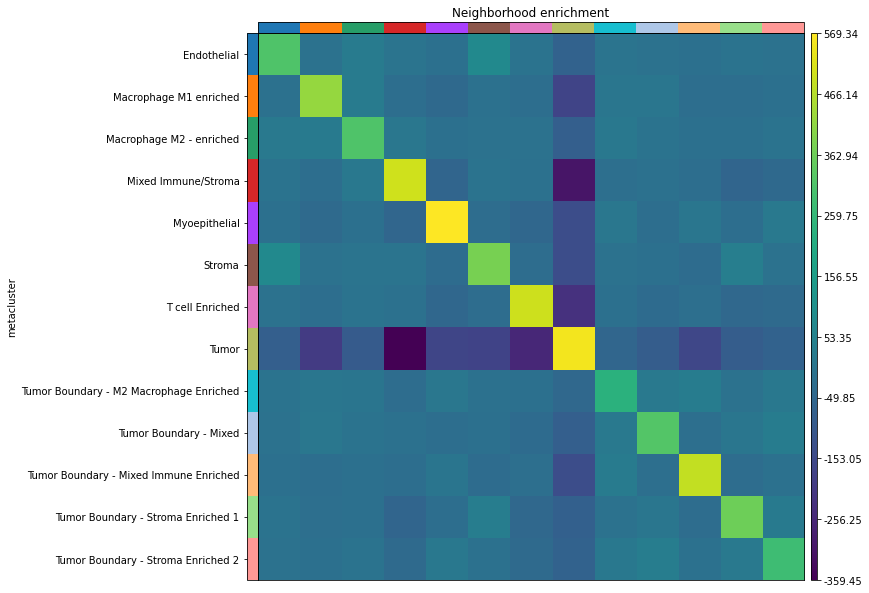

In [23]:
sq.pl.nhood_enrichment(a, cluster_key='metacluster')

2022-08-05 16:41:00,396 : DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f79e8a576d0>
2022-08-05 16:41:00,402 : DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f79e8afba50>
2022-08-05 16:41:00,407 : DEBUG : locator: <matplotlib.ticker.FixedLocator object at 0x7f79e89f3c90>
2022-08-05 16:41:00,429 : DEBUG : Executing constrainedlayout
2022-08-05 16:41:00,432 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:41:00,438 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:41:00,441 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:41:00,500 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:41:00,536 : DEBUG : top of Axes not in the figure, so title not moved
2022-08-05 16:41:00,556 : DEBUG : top of Axes not in the figure, so title not moved


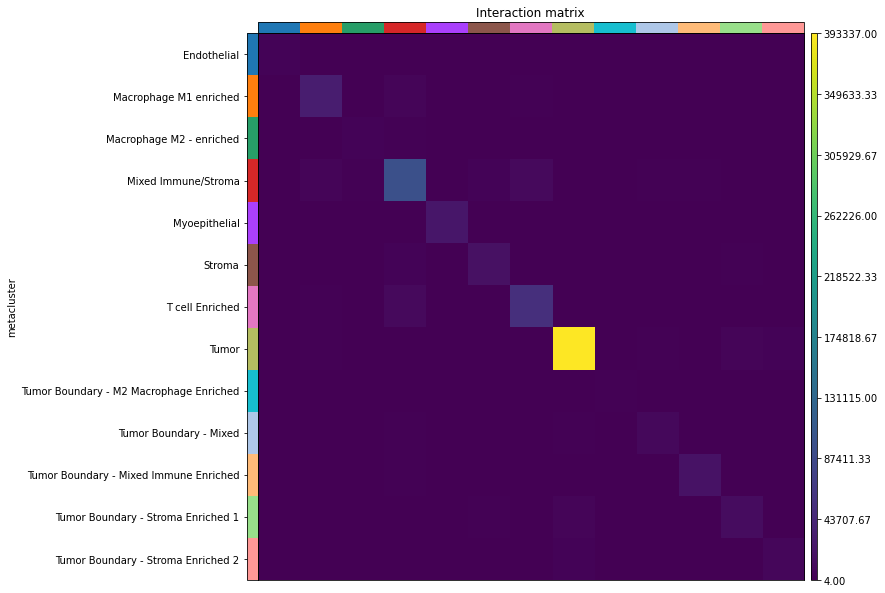

In [21]:
sq.pl.interaction_matrix(a, cluster_key="metacluster")